# M3R Numerics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nsimpkg.random_variables import NormalRV
from nsimpkg.gaussian_OAIS import SG_OAIS, ADAM_OAIS, AdaGrad_OAIS
from nsimpkg.mcsim import mcsim, rho
from nsimpkg.plotting import plotter, plot_contours


plt.rcParams['figure.dpi'] = 300


## Intro

Note that our update step is:

$$
\theta_{n+1}\leftarrow \theta_n - \alpha \nabla \rho(\theta)
$$

In our case, as both distributions are normal, we can use the fundamental representation of the normal distribution so that its pdf is in the exponential family. This means that:

$$
\nabla \rho(\theta) = -\mathbb{E}_{q_\theta}\left[\frac{\pi^2(x)}{q^2_\theta(x)}\nabla_\theta\log q_\theta(x)\right]
$$

Then, as $\theta = (\mu, \Sigma)$ and using the fundamental representation of the normal distribution we arrive to:

$$
\begin{align*}
\frac{\partial \log q_\theta}{\partial m}(x) &= \mu-x\\
\frac{\partial \log q_\theta}{\partial S}(x) &= \frac{1}{2}(xx^\top - S^{-1}mm^\top S^{-1} - S^{-1}) = \frac{1}{2}(xx^\top - \mu\mu^\top - \Sigma)
\end{align*}
$$

Therefore, we will implement gradient descent on $S$ and $m$, which is just are just invertible functions of $\Sigma$ and $\mu$.

We now implement functions to compute the gradient descent update, using the equations above:

We now implement OAIS, using the following steps for each iteration:

1. Sample $x\sim q_\theta(x)$
2. Compute $w_\theta(x) = \frac{\pi(x)}{q_\theta(x)}$
3. Estimate $(\phi, \pi_\theta^N)$ using the samples $x$ and $w_\theta(x)$
4. Update $\theta$ using the gradient descent by doing:
   1. Compute $\frac{\partial \log \rho}{\partial m}$ and update $m$
   2. Compute $\frac{\partial \log \rho}{\partial S}$ and update $S$ (project to PSD cone if needed)
   

Let $Sq=[-1,\,1]^2$. We now test OAIS by using the test function $\phi(x) = 1_{Sq}(x)$. The target distribution will be:

$$
\pi\sim \mathcal{N}\left([1, -1]^\top, \begin{bmatrix} 2 & -0.5 \\ -0.5 & 2 \end{bmatrix}\right)
$$

And our initial proposal will be:
$$
q_{\theta_0} \sim \mathcal{N}\left([5, -5]^\top, \begin{bmatrix} 40 & 0 \\ 0 & 40 \end{bmatrix}\right)
$$

We estimate $\mathbb{P}(\pi\in Sq)$ using a Monte Carlo estimate with $N=10^6$ samples to obtain a reference value. To do this, we note that:

$$
\mathbb{P}(\pi\in Sq) = \int_{R_n}1_{Sq}(x)\pi(x)dx = \mathbb{E}[1_{Sq}(x)]\approx \frac{1}{N}\sum_{i=1}^N 1_{Sq}(x_i)
$$

Below, we define the functions to compute the reference value and the test function $\phi(x) = 1_{Sq}(x)$.

In [2]:
q = NormalRV(np.array([10, -10]), np.array([[40, 0], [0, 40]]))
pi = NormalRV(np.array([1, -1]), np.array([[2, -0.5], [-0.5, 2]]))

def phi(x):
    return (np.sum(np.abs(x) < 1, axis=0) == 2).astype(int)

Analytically, $P(\pi\in Sq) = 0.195595$

In [3]:
GT = 0.195595

We now compute the OAIS estimate of $\mathbb{P}(\pi\in Sq)$ using $N=100$ samples at each iteration. We will run the algorithm for $10^5$ iterations, and the learning rate at iteration $k$ will be set to $\alpha_k = \frac{10^{-4}}{k}$.

In [5]:
N = 100
Niter = int(1e4)

SG_all_results = []
SG_all_distributions = []
ADAM_all_results = []
ADAM_all_distributions = []
AdaGrad_all_results = []
AdaGrad_all_distributions = []
n_experiments = 3
for i in range(n_experiments):
    r_sg, d_sg = SG_OAIS(phi, pi, q, N, Niter, alpha=1e-5, proj_eps=1e-12, proj_set=1e-3, fixed=True)
    SG_all_results.append(r_sg)
    SG_all_distributions.append(d_sg)

    r_adam, d_adam = ADAM_OAIS(phi, pi, q, N, Niter, alpha=0.007)
    ADAM_all_results.append(r_adam)
    ADAM_all_distributions.append(d_adam)

    r_adagrad, d_adagrad = ADAM_OAIS(phi, pi, q, N, Niter, alpha=0.01)
    AdaGrad_all_results.append(r_adagrad)
    AdaGrad_all_distributions.append(d_adagrad)

100%|██████████| 10000/10000 [00:13<00:00, 734.52it/s]


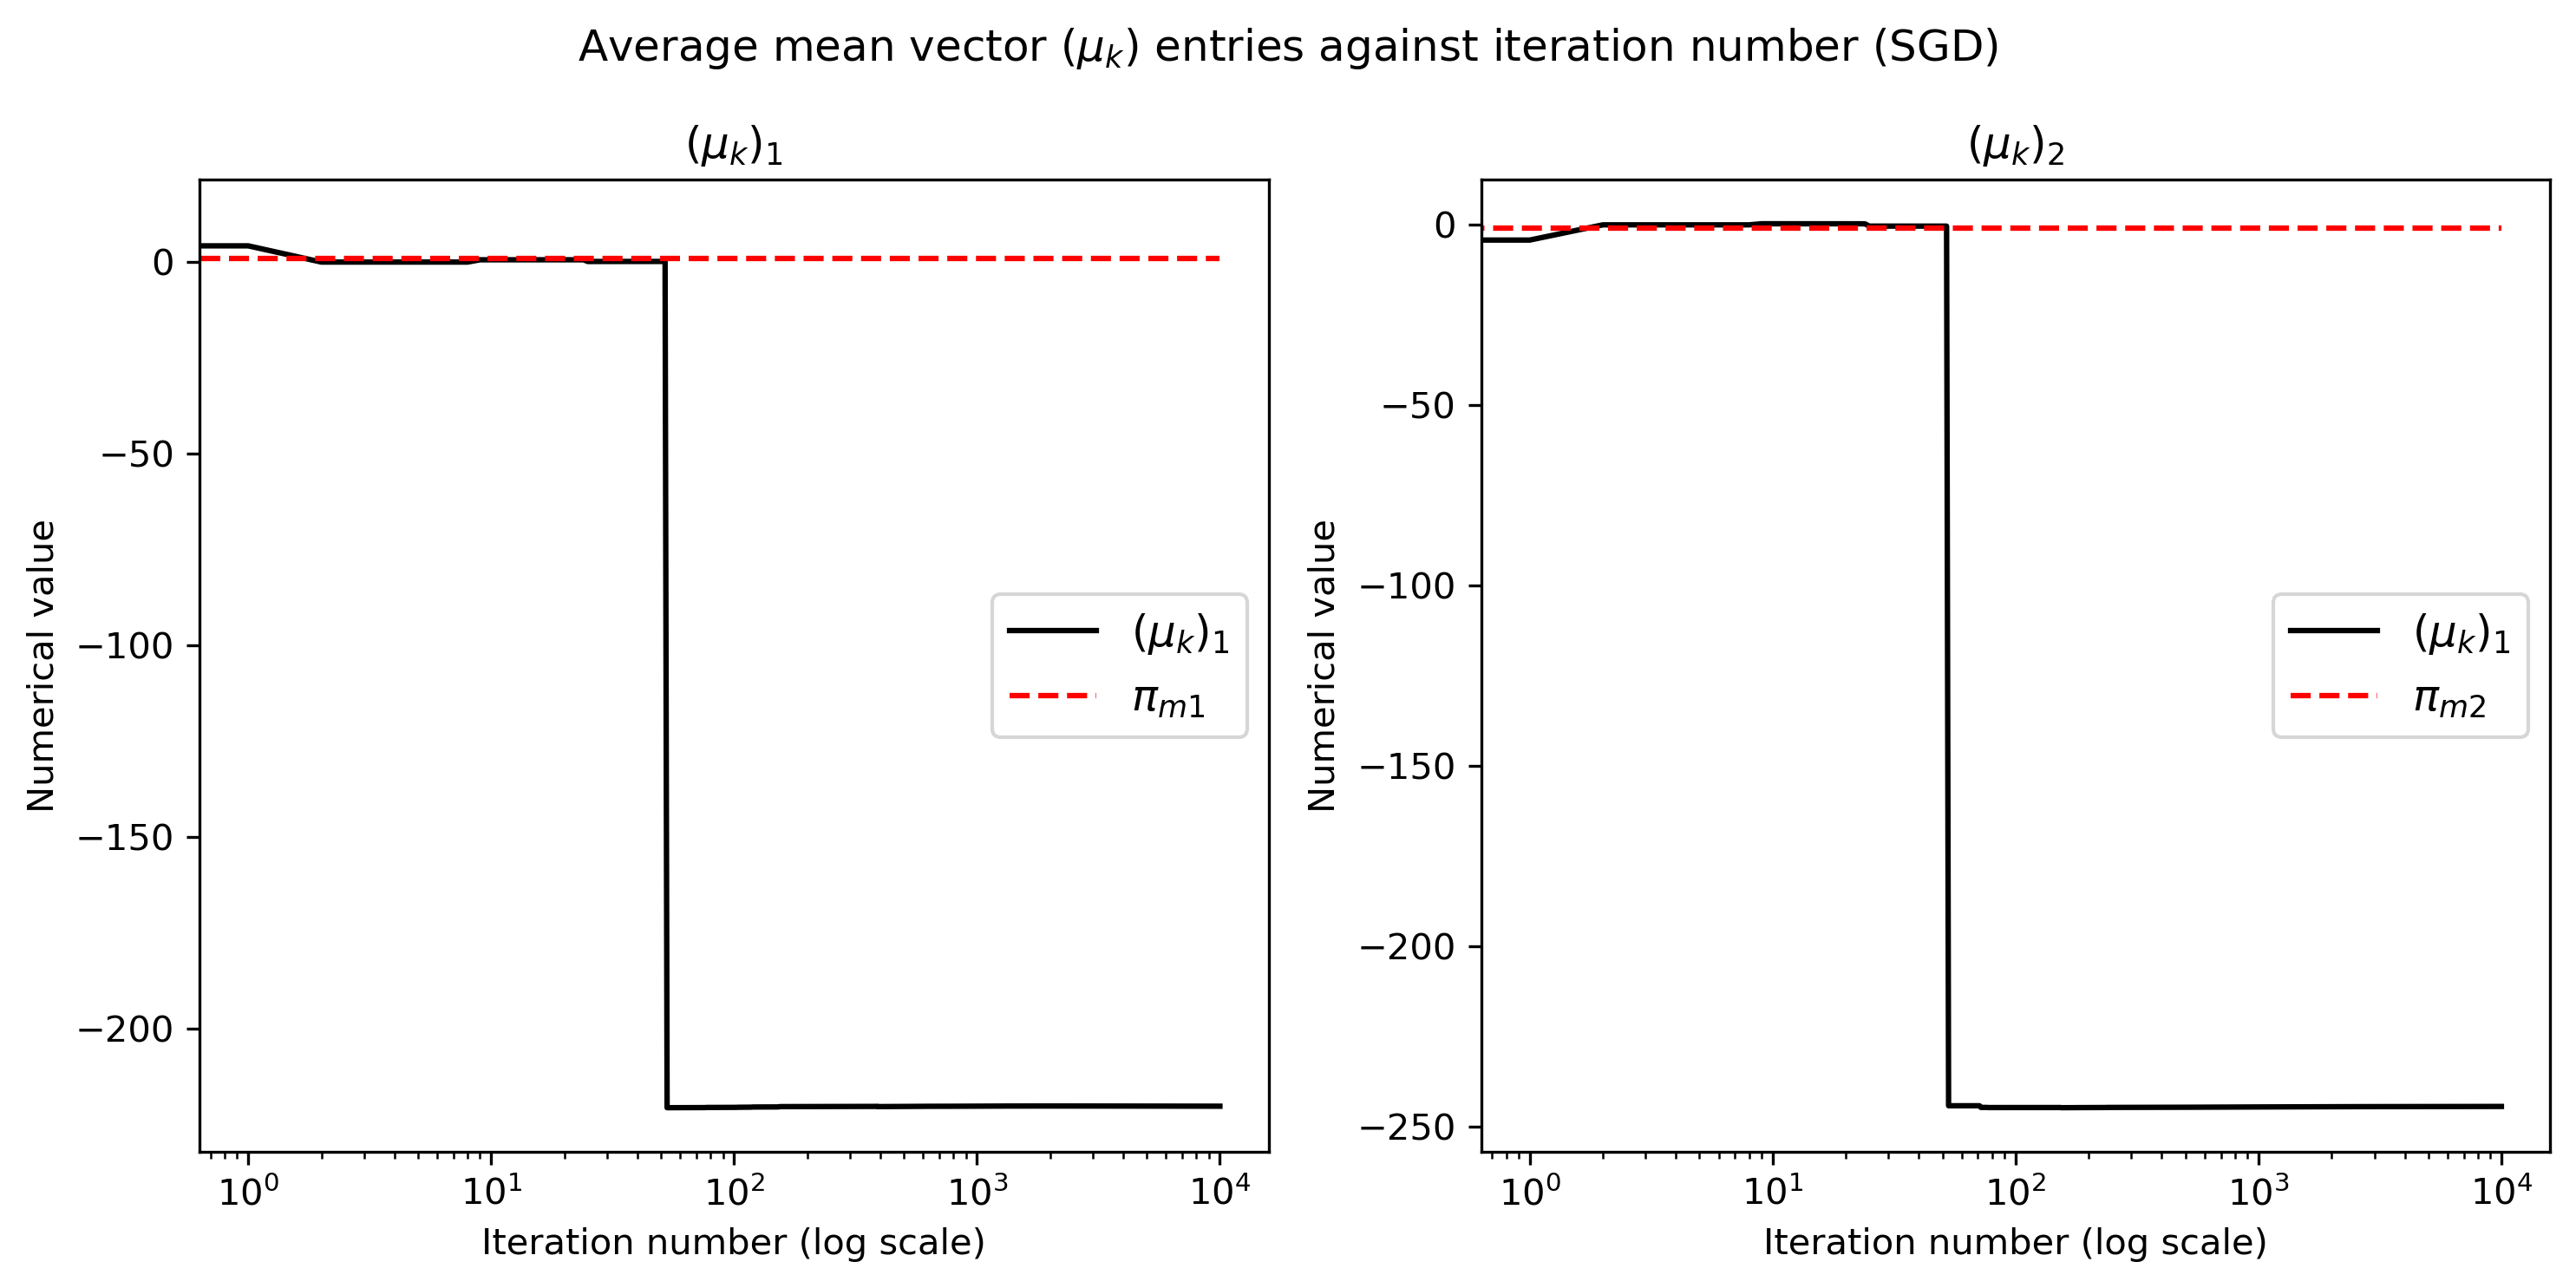

In [13]:
plotter(SG_all_distributions, pi, "SG all", kind="mean", average=True)
plt.show()

In [14]:
SG_averaged_results = np.mean(np.array(SG_all_results), axis=0)
ADAM_averaged_results = np.mean(np.array(ADAM_all_results), axis=0)

SG_average_sigmas = [np.zeros((2,2)) for _ in range(Niter+1)]
SG_average_mus = [np.zeros(2) for _ in range(Niter+1)]
ADAM_average_sigmas = [np.zeros((2,2)) for _ in range(Niter+1)]
ADAM_average_mus = [np.zeros(2) for _ in range(Niter+1)]

for i in range(n_experiments):
    SG_d_i = SG_all_distributions[i]
    ADAM_d_i = ADAM_all_distributions[i]
    for j in range(Niter+1):
        SG_average_sigmas[j] += SG_d_i[j].Sigma/n_experiments
        SG_average_mus[j] += SG_d_i[j].mu/n_experiments
        ADAM_average_sigmas[j] += ADAM_d_i[j].Sigma/n_experiments
        ADAM_average_mus[j] += ADAM_d_i[j].mu/n_experiments

SG_average_distributions = [NormalRV(SG_average_mus[i], SG_average_sigmas[i], natural=False) for i in range(Niter+1)]
ADAM_average_distributions = [NormalRV(ADAM_average_mus[i], ADAM_average_sigmas[i], natural=False) for i in range(Niter+1)]

In [15]:
def fill_z(p, npoints=100):
    X = np.linspace(-20, 20, npoints)
    Y = np.linspace(-20, 20, npoints)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((npoints, npoints))
    for i in range(npoints):
        for j in range(npoints):
            Z[i,j] = p.pdf(np.array([X[i,j], Y[i,j]]))
    return X, Y, Z

In [16]:
dist_to_get = [0, Niter//4, 2*Niter//4, 3*Niter//4, Niter]

## Plots for SGD

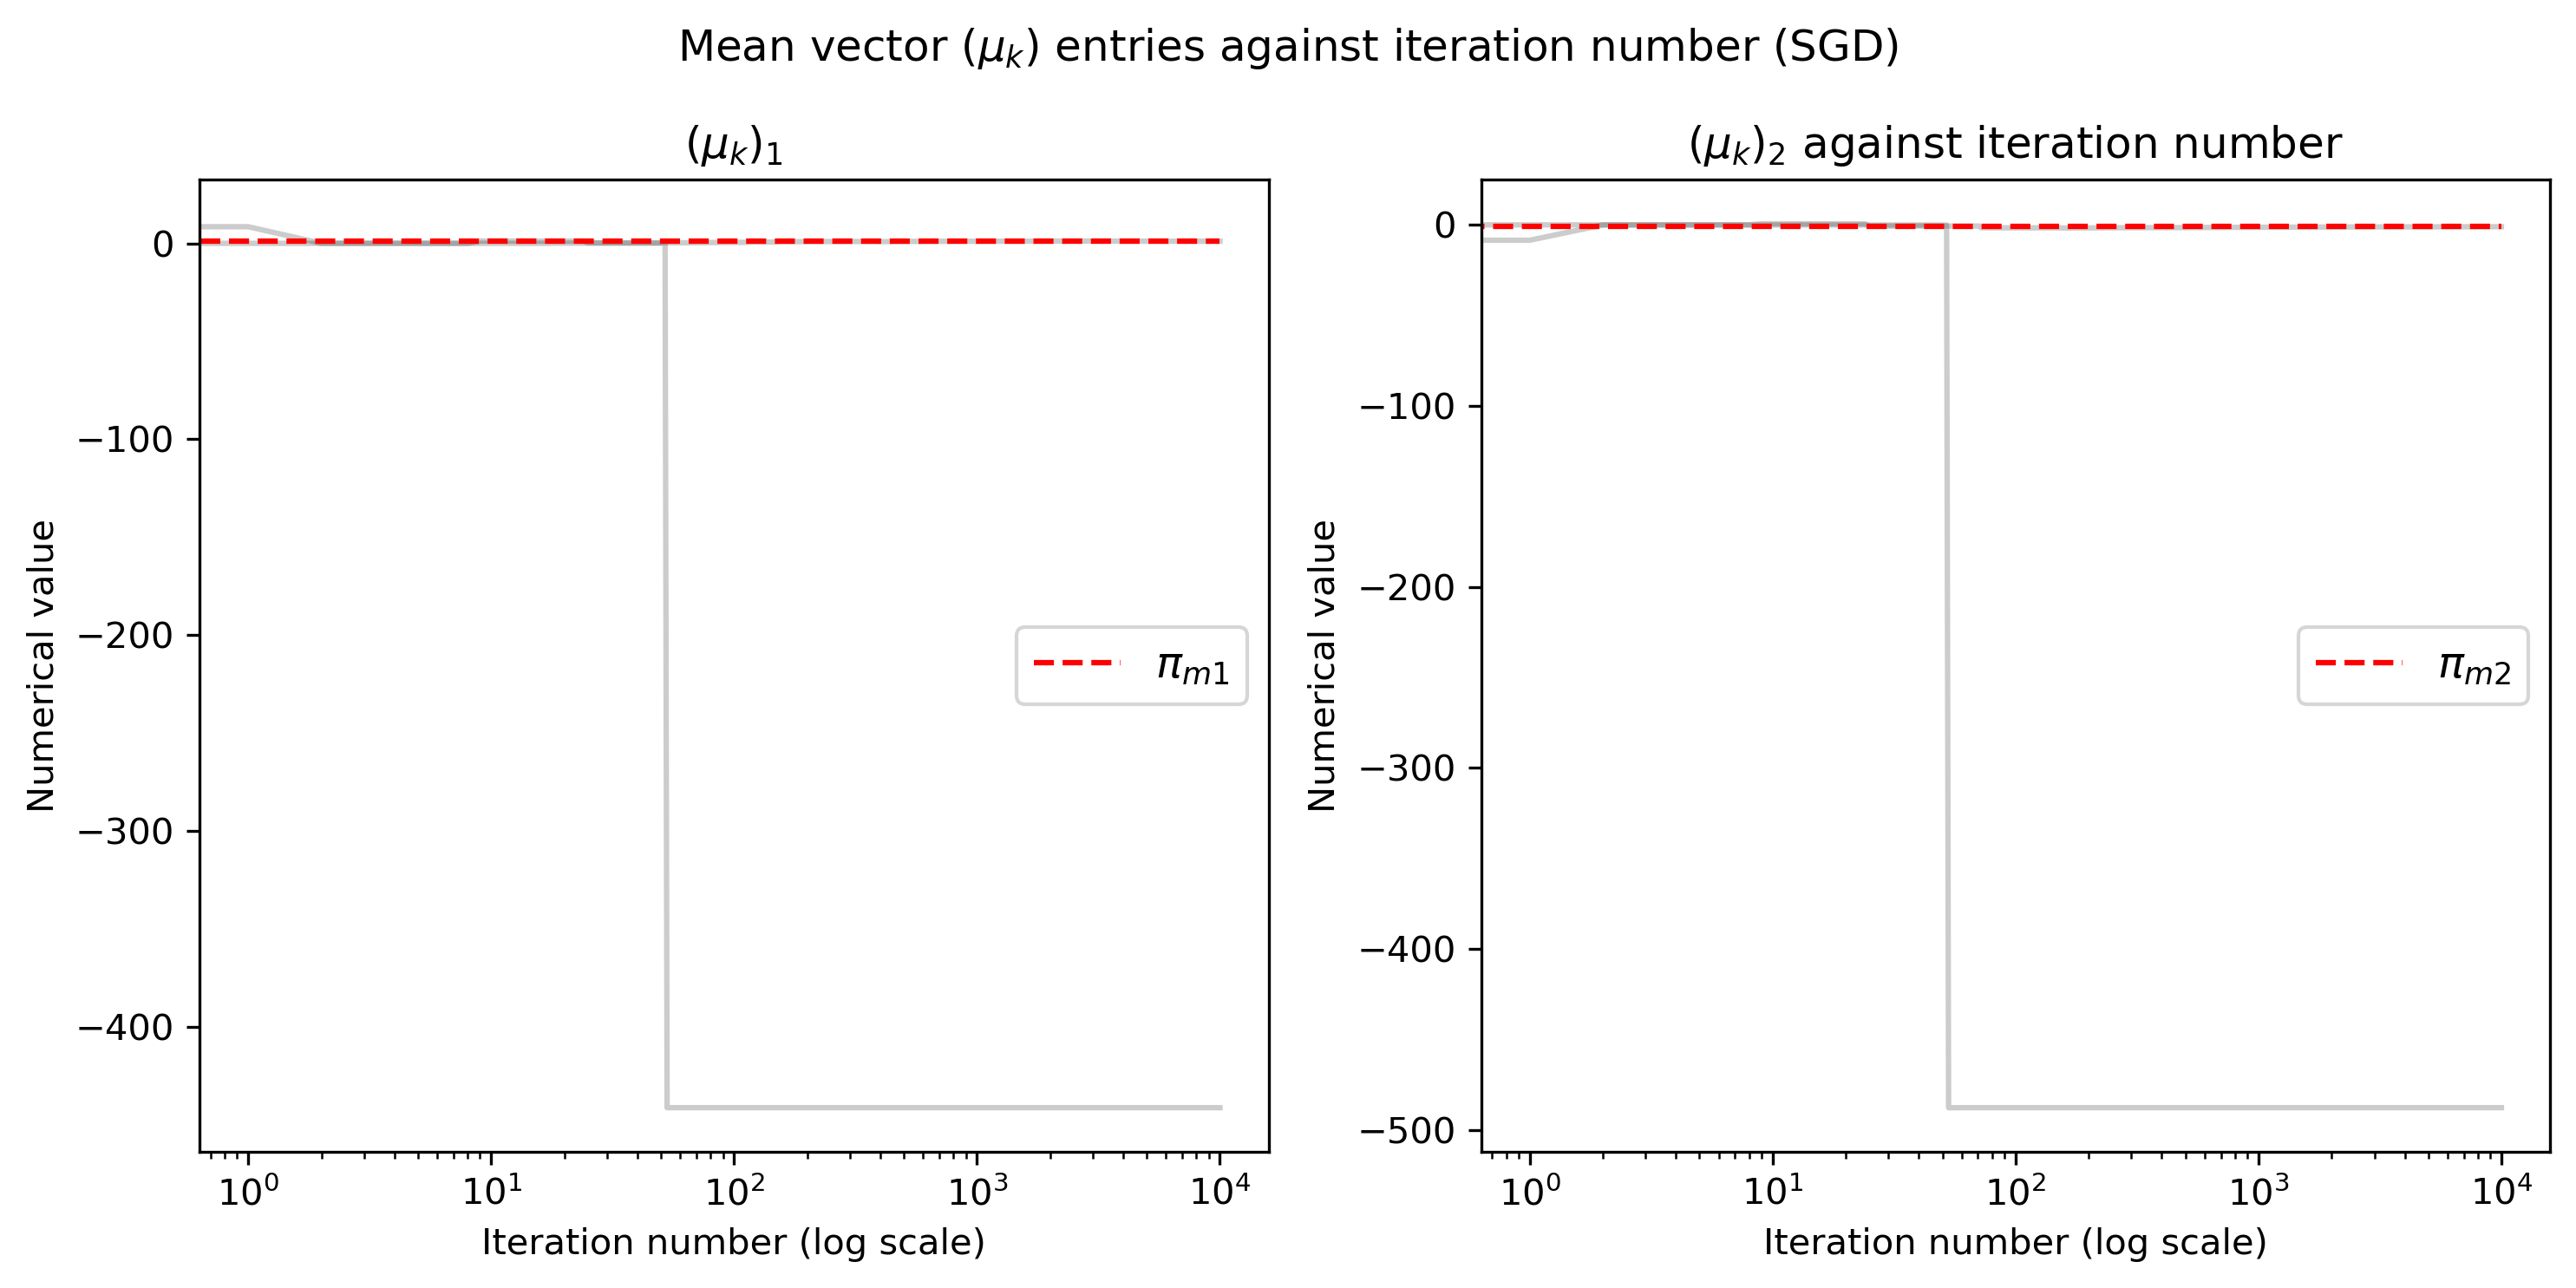

In [17]:
#mu1 = [average_distributions[i].mu[0] for i in range(0, Niter)]
#mu2 = [average_distributions[i].mu[1] for i in range(0, Niter)]

# make 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.plot(mu1, label="$(\mu_k)_1$", color="black")
for i, distribution_list in enumerate(SG_all_distributions):
    mu_1 = [d.mu[0] for d in distribution_list]
    mu_2 = [d.mu[1] for d in distribution_list]
    ax1.plot(mu_1, color="black", alpha=0.2)
    ax2.plot(mu_2, color="black", alpha=0.2)
ax1.hlines(pi.mu[0], 0, Niter, label="$\pi_{m1}$", color="red", linestyle="--")
ax1.legend(loc="center right", fontsize=12)
ax1.set_xlabel("Iteration number (log scale)")
ax1.set_ylabel("Numerical value")
ax1.set_title("$(\mu_k)_1$")
ax1.set_xscale("log")

#ax2.plot(mu2, label="$(\mu_k)_2$", color="black")
ax2.set_xscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Iteration number (log scale)")
ax2.set_ylabel("Numerical value")
ax2.set_title("$(\mu_k)_2$ against iteration number")
ax2.hlines(pi.mu[1], 0, Niter, label="$\pi_{m2}$", color="red", linestyle="--")
ax2.legend(loc="center right", fontsize=12)
fig.suptitle("Mean vector $(\mu_k)$ entries against iteration number (SGD)")
fig.tight_layout()
plt.show()

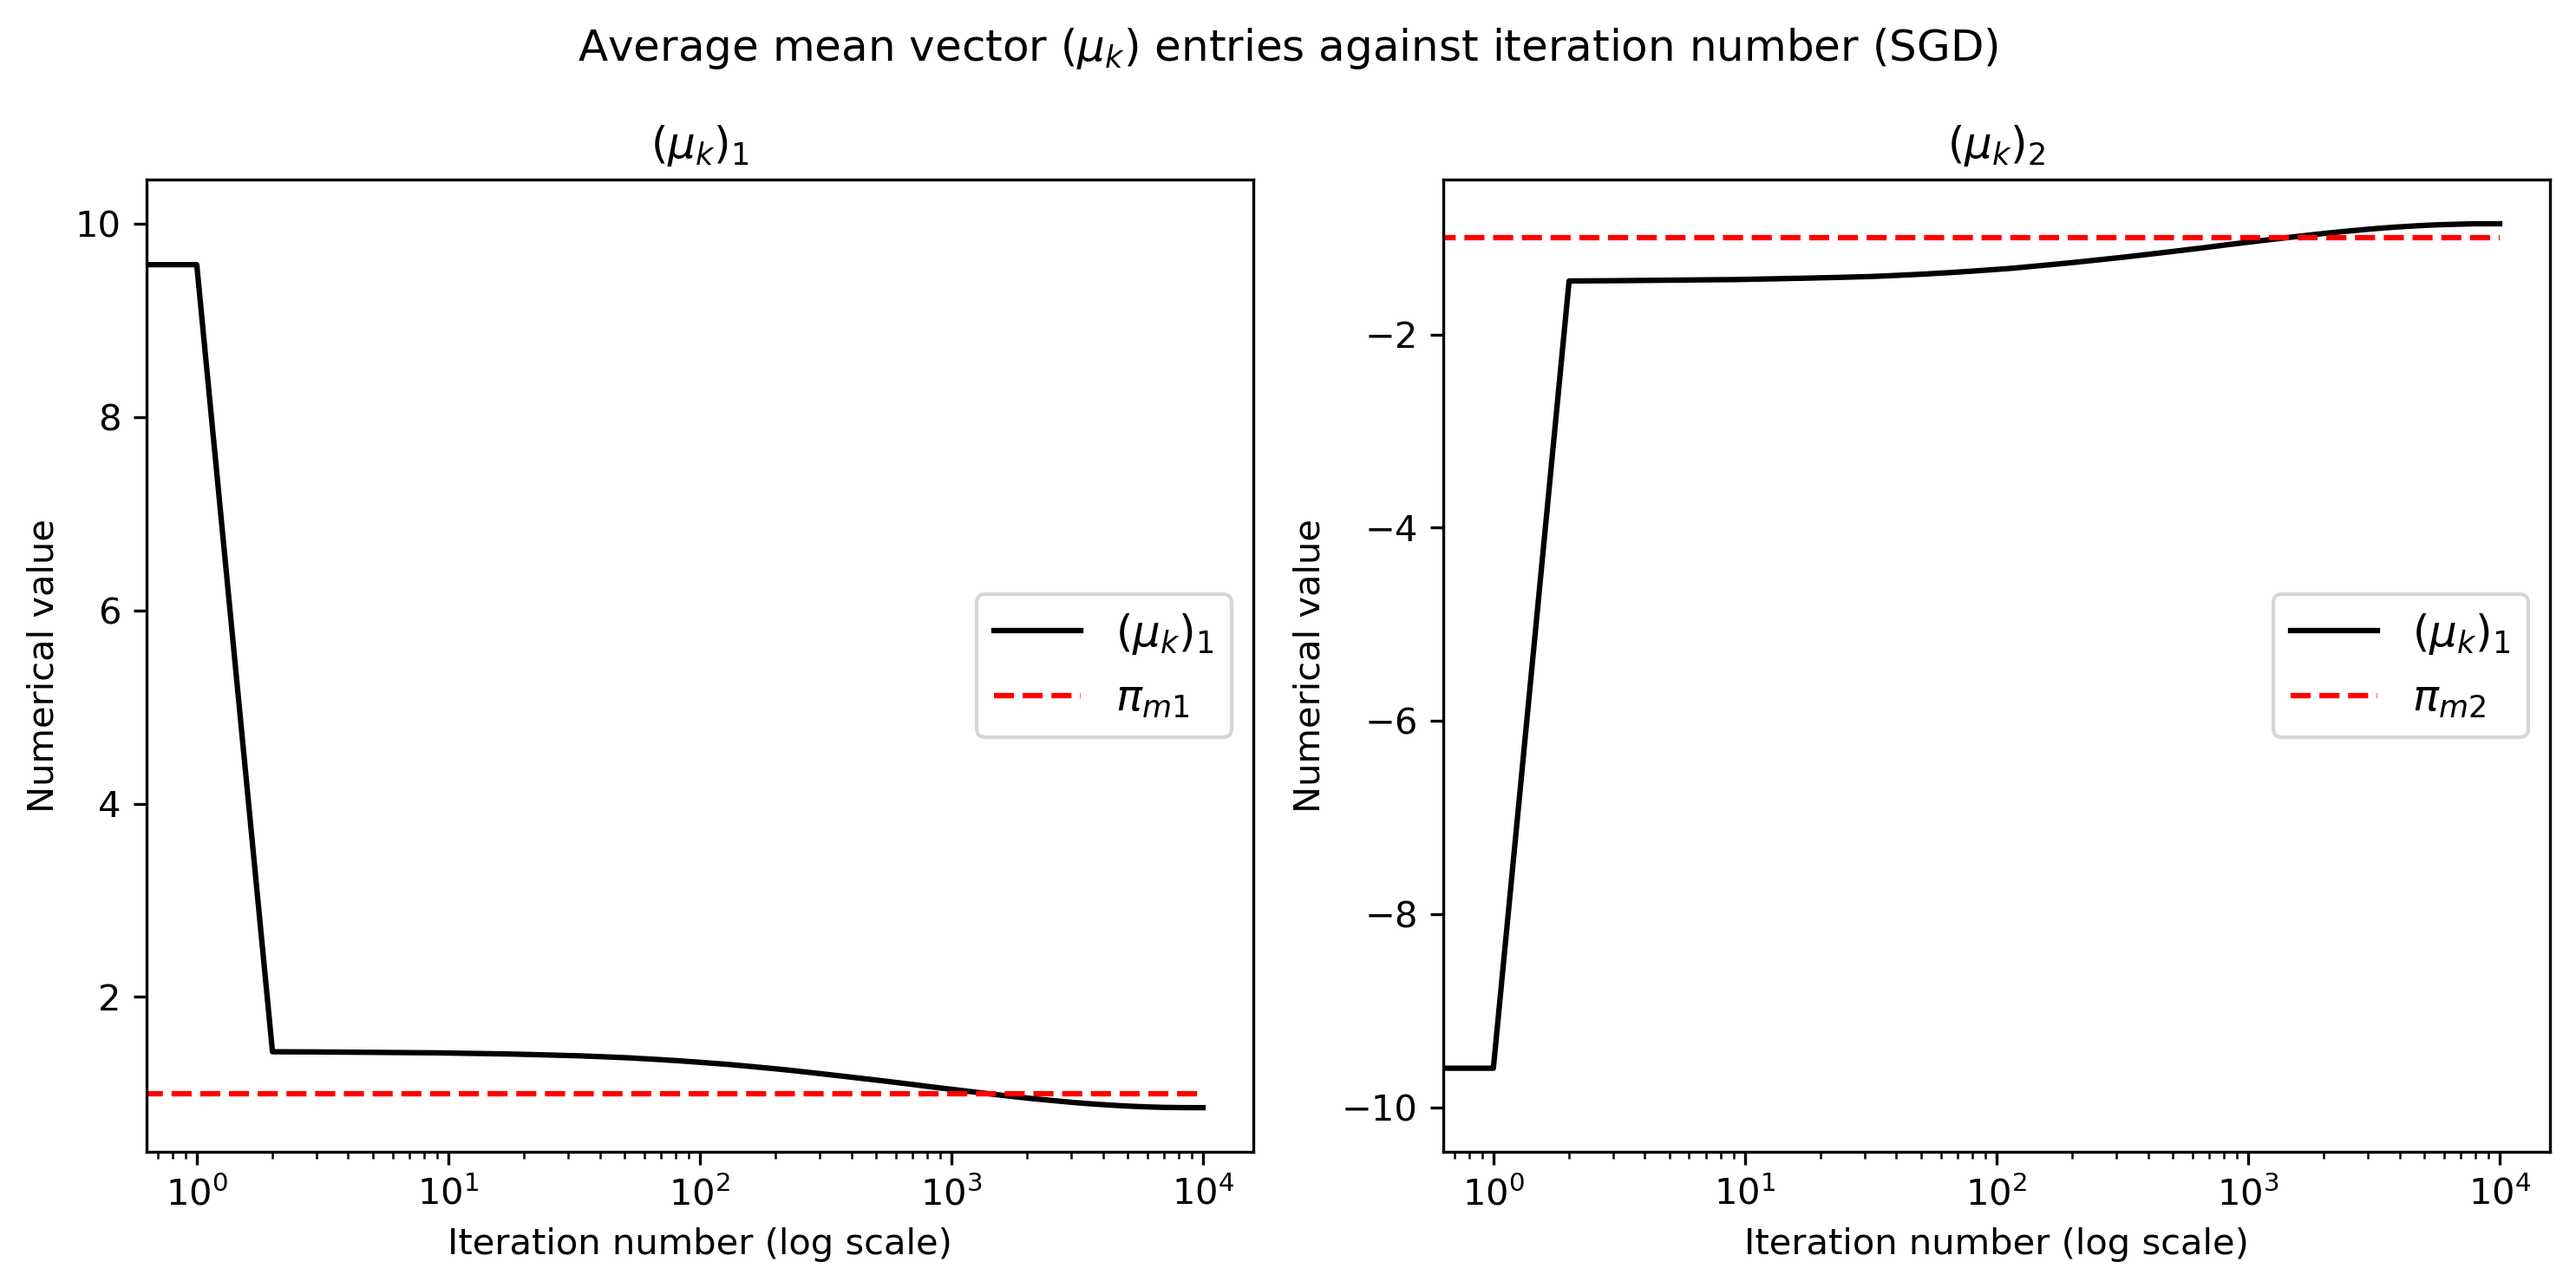

In [10]:
#mu1 = [average_distributions[i].mu[0] for i in range(0, Niter)]
#mu2 = [average_distributions[i].mu[1] for i in range(0, Niter)]

# make 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.plot(mu1, label="$(\mu_k)_1$", color="black")
ax1.plot([d.mu[0] for d in SG_average_distributions], label="$(\mu_k)_1$", color="black")
ax1.hlines(pi.mu[0], 0, Niter, label="$\pi_{m1}$", color="red", linestyle="--")
ax1.legend(loc="center right", fontsize=12)
ax1.set_xlabel("Iteration number (log scale)")
ax1.set_ylabel("Numerical value")
ax1.set_title("$(\mu_k)_1$")
ax1.set_xscale("log")

#ax2.plot(mu2, label="$(\mu_k)_2$", color="black")
ax2.plot([d.mu[1] for d in SG_average_distributions], label="$(\mu_k)_1$", color="black")
ax2.set_xscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Iteration number (log scale)")
ax2.set_ylabel("Numerical value")
ax2.set_title("$(\mu_k)_2$")
ax2.hlines(pi.mu[1], 0, Niter, label="$\pi_{m2}$", color="red", linestyle="--")
ax2.legend(loc="center right", fontsize=12)
fig.suptitle("Average mean vector $(\mu_k)$ entries against iteration number (SGD)")
fig.tight_layout()
plt.show()

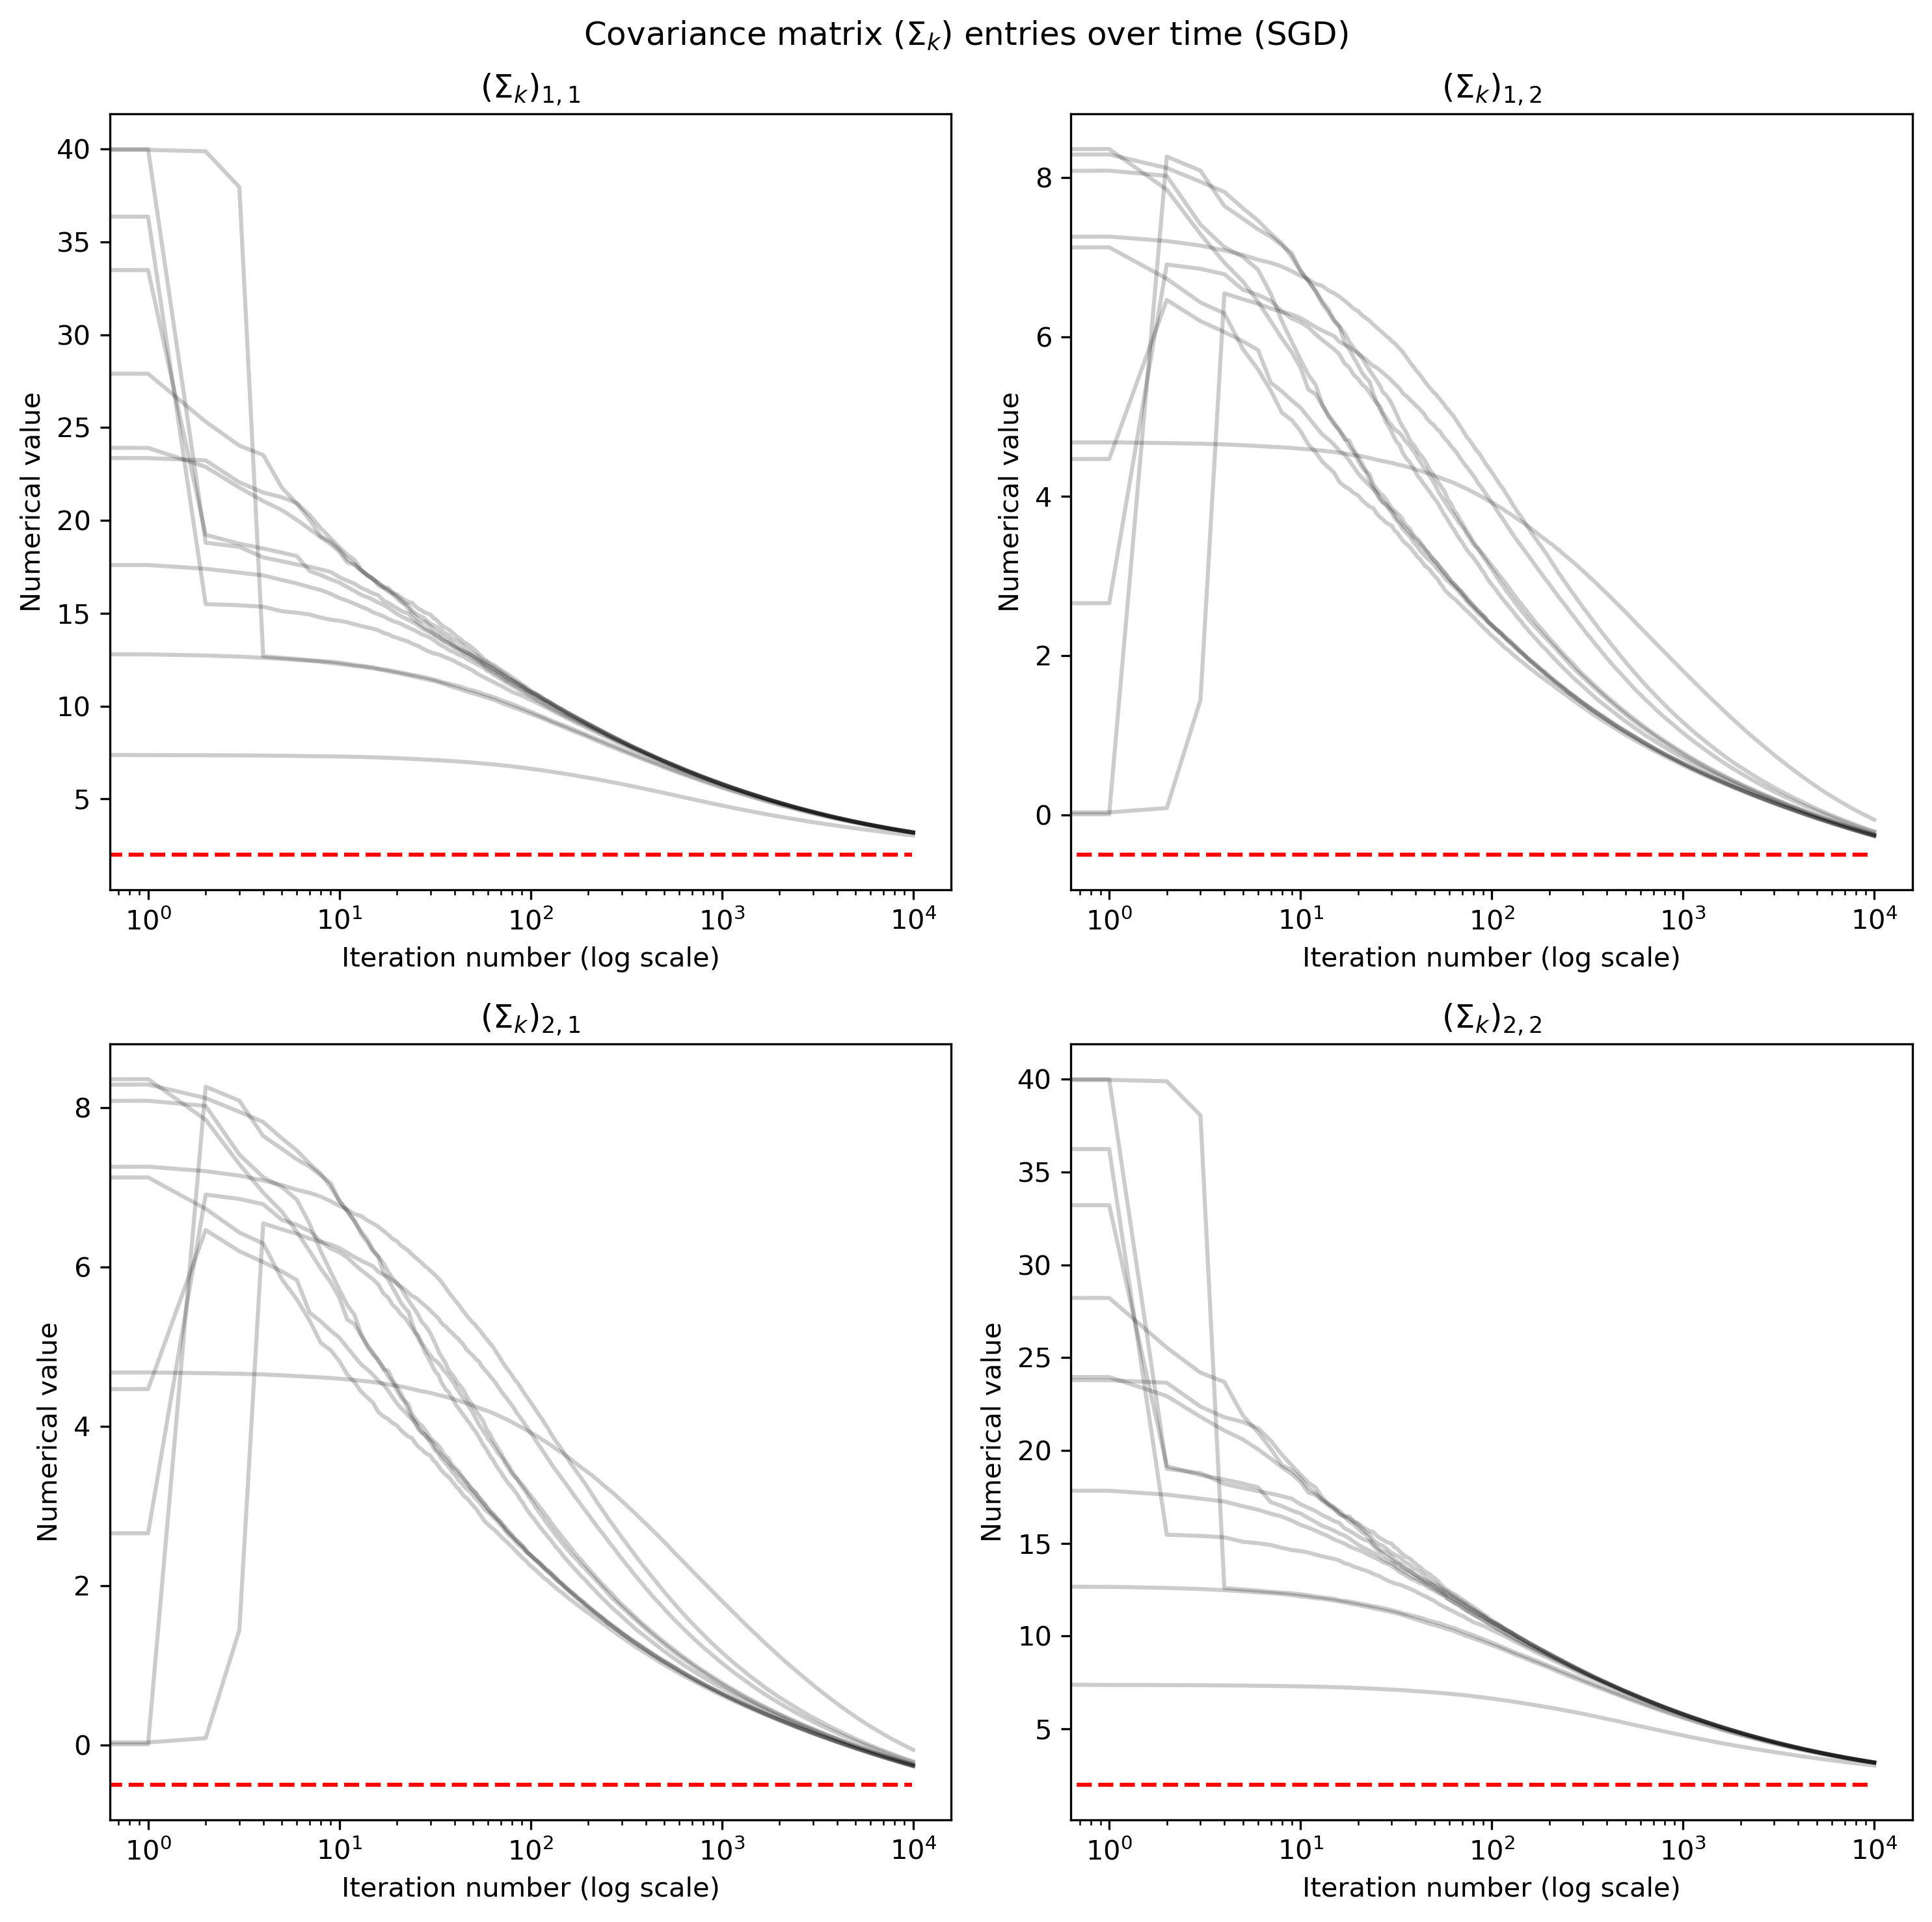

In [11]:
#sigma00 = [distributions[i].Sigma[0][0] for i in range(0, Niter)]
#sigma11 = [distributions[i].Sigma[1][1] for i in range(0, Niter)]
#sigma01 = [distributions[i].Sigma[0][1] for i in range(0, Niter)]
#sigma10 = [distributions[i].Sigma[1][0] for i in range(0, Niter)]
true = pi.Sigma
true00 = true[0][0]
true11 = true[1][1]
true01 = true[0][1]
true10 = true[1][0]
# make 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, distribution_list in enumerate(SG_all_distributions):
    sigma00 = [d.Sigma[0][0] for d in distribution_list]
    sigma10 = [d.Sigma[1][0] for d in distribution_list]
    sigma01 = [d.Sigma[0][1] for d in distribution_list]
    sigma11 = [d.Sigma[1][1] for d in distribution_list]
    axs[0, 0].plot(sigma00, color="black", alpha=0.2)
    axs[1, 0].plot(sigma10, color="black", alpha=0.2)
    axs[0, 1].plot(sigma01, color="black", alpha=0.2)
    axs[1, 1].plot(sigma11, color="black", alpha=0.2)

axs[0, 0].hlines(y=true00, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 0].set_title('$(\Sigma_k)_{1,1}$')
axs[0, 1].hlines(y=true01, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 1].set_title('$(\Sigma_k)_{1,2}$')
axs[1, 0].hlines(y=true10, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 0].set_title('$(\Sigma_k)_{2,1}$')
axs[1, 1].hlines(y=true11, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 1].set_title('$(\Sigma_k)_{2,2}$')
for ax in axs.flat:
    #ax.set(xlabel='iteration (log scale)', ylabel='sigma')
    # set x-axis to log scale
    ax.set_xscale('log')
    ax.set_xlabel("Iteration number (log scale)")
    ax.set_ylabel("Numerical value")
fig.suptitle('Covariance matrix $(\Sigma_k)$ entries over time (SGD)')
fig.tight_layout()
plt.show()
# plot entries of the covariance matrix

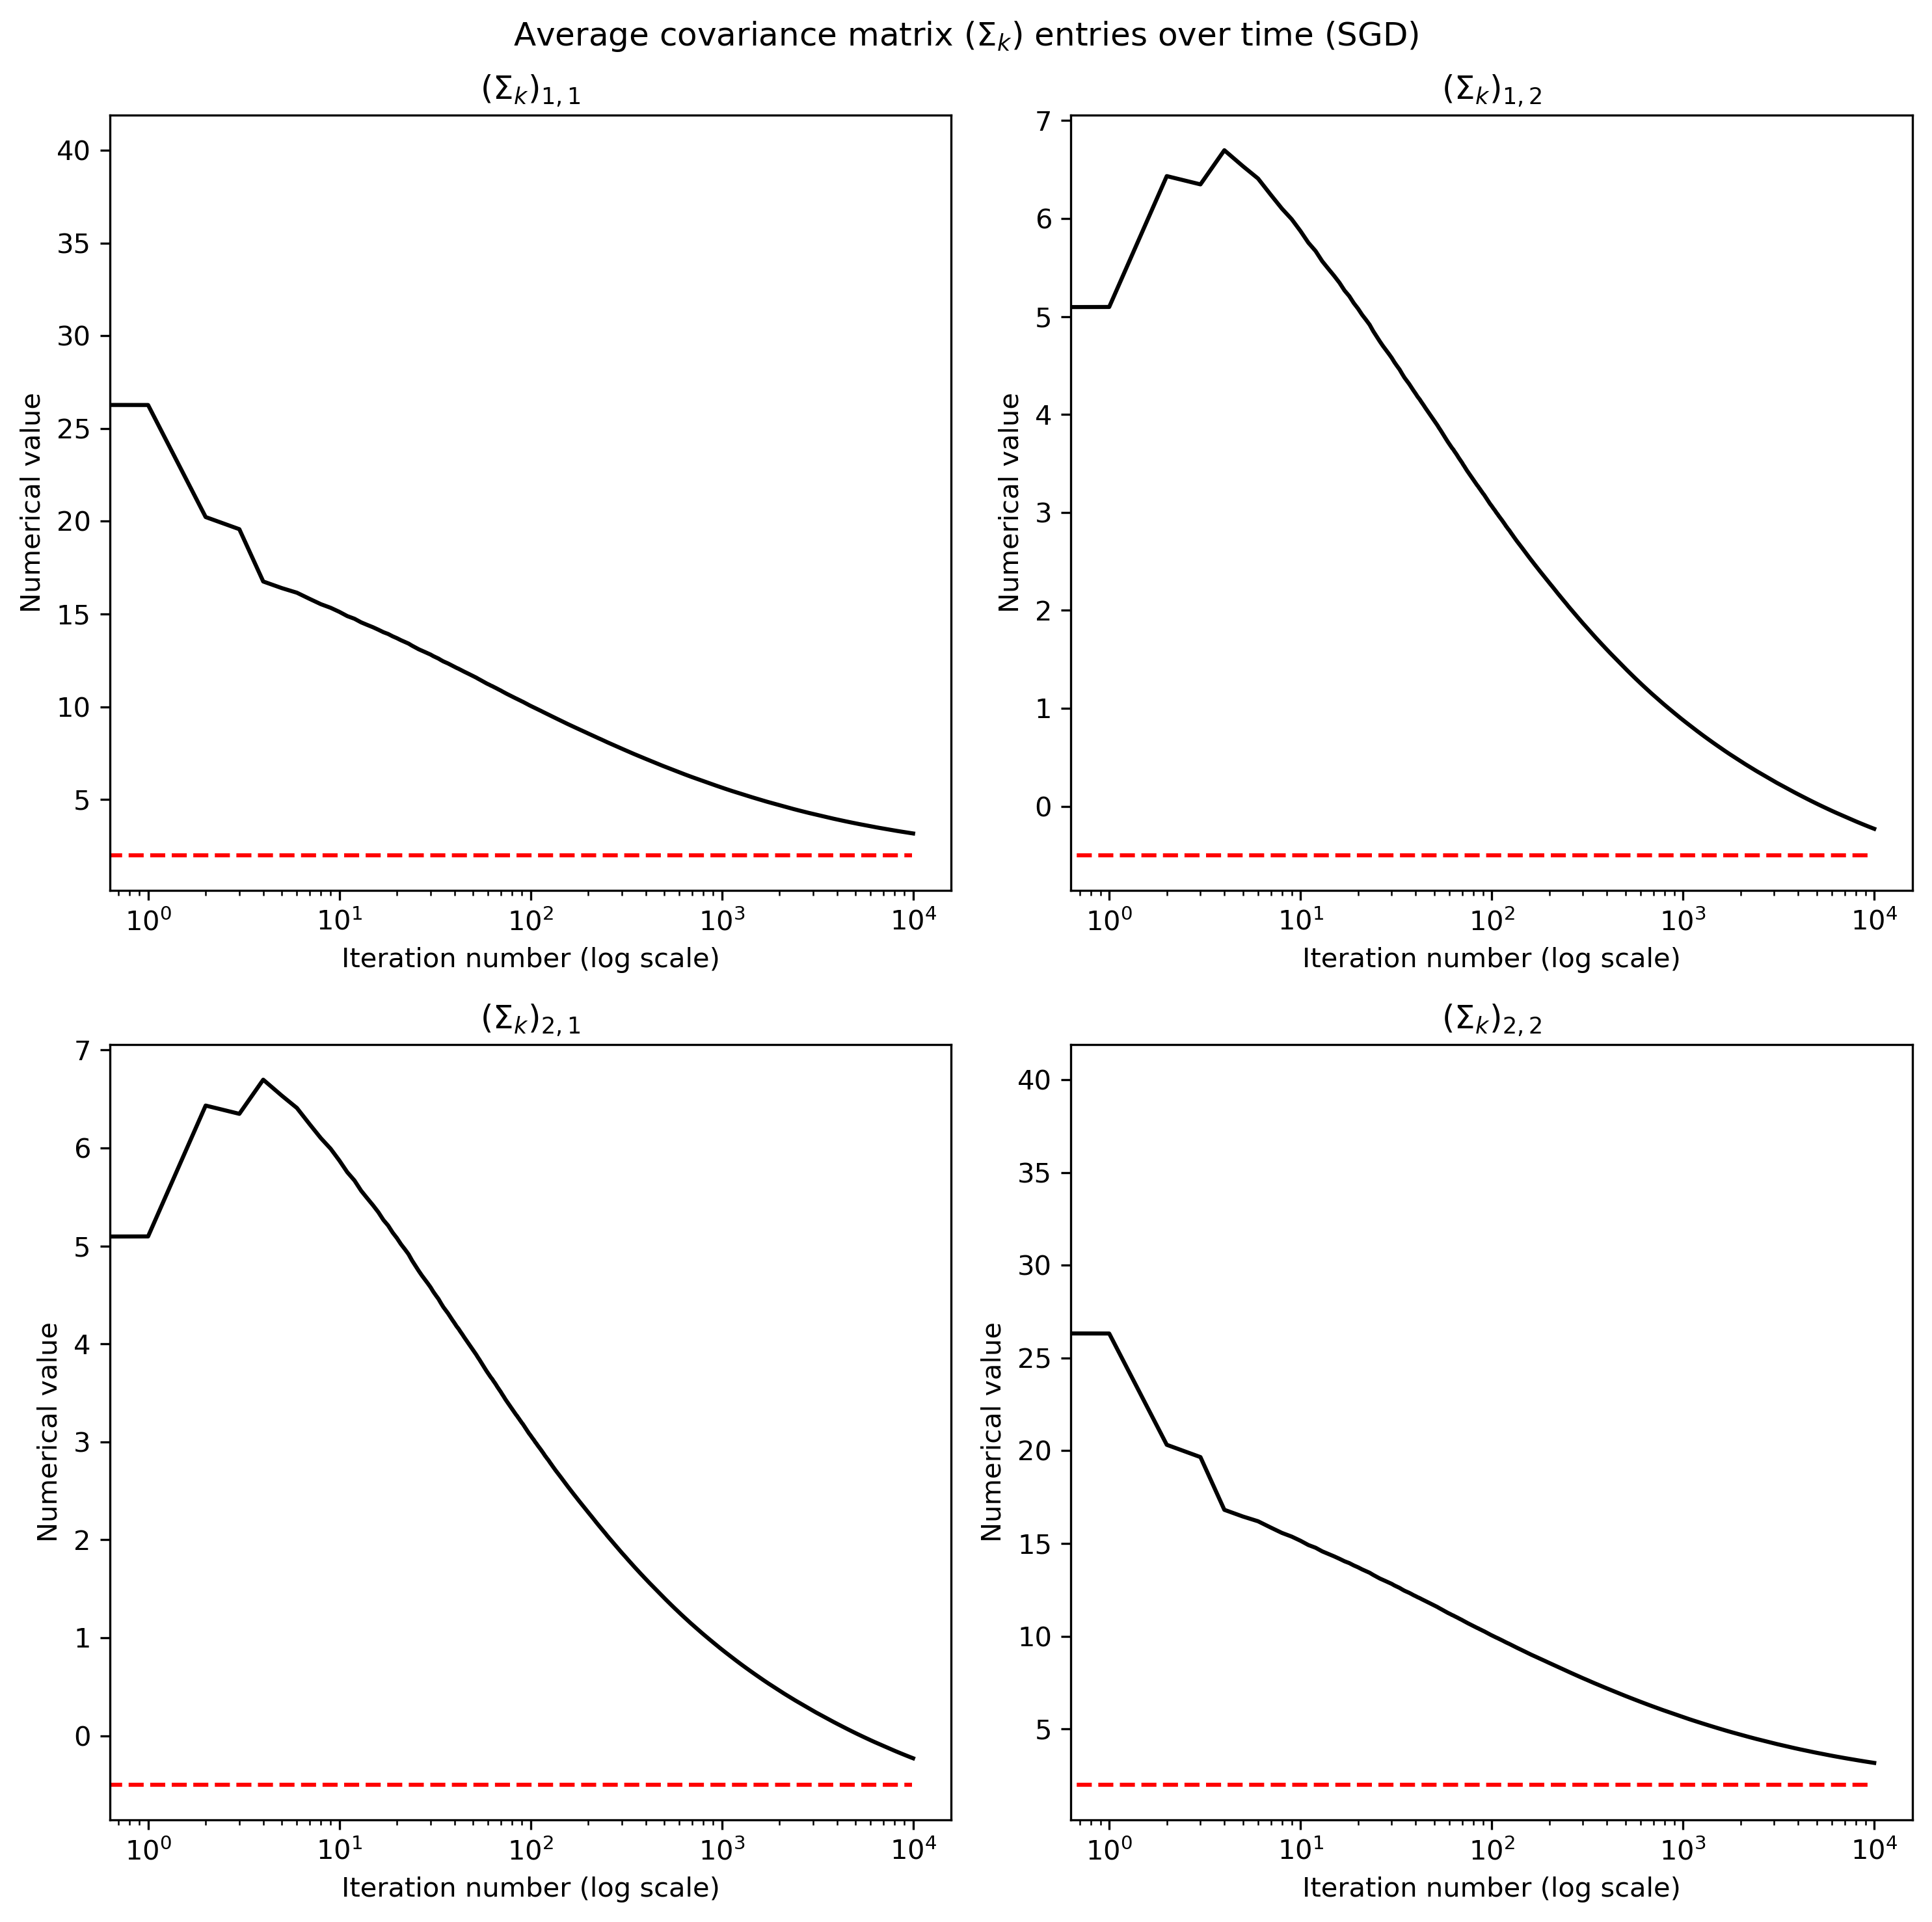

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

sigma00 = [d.Sigma[0][0] for d in SG_average_distributions]
sigma10 = [d.Sigma[1][0] for d in SG_average_distributions]
sigma01 = [d.Sigma[0][1] for d in SG_average_distributions]
sigma11 = [d.Sigma[1][1] for d in SG_average_distributions]
axs[0, 0].plot(sigma00, color="black")
axs[1, 0].plot(sigma10, color="black")
axs[0, 1].plot(sigma01, color="black")
axs[1, 1].plot(sigma11, color="black")

axs[0, 0].hlines(y=true00, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 0].set_title('$(\Sigma_k)_{1,1}$')
axs[0, 1].hlines(y=true01, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 1].set_title('$(\Sigma_k)_{1,2}$')
axs[1, 0].hlines(y=true10, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 0].set_title('$(\Sigma_k)_{2,1}$')
axs[1, 1].hlines(y=true11, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 1].set_title('$(\Sigma_k)_{2,2}$')
for ax in axs.flat:
    #ax.set(xlabel='iteration (log scale)', ylabel='sigma')
    # set x-axis to log scale
    ax.set_xscale('log')
    ax.set_xlabel("Iteration number (log scale)")
    ax.set_ylabel("Numerical value")
fig.suptitle('Average covariance matrix $(\Sigma_k)$ entries over time (SGD)')
fig.tight_layout()
plt.show()
# plot entries of the covariance matrix

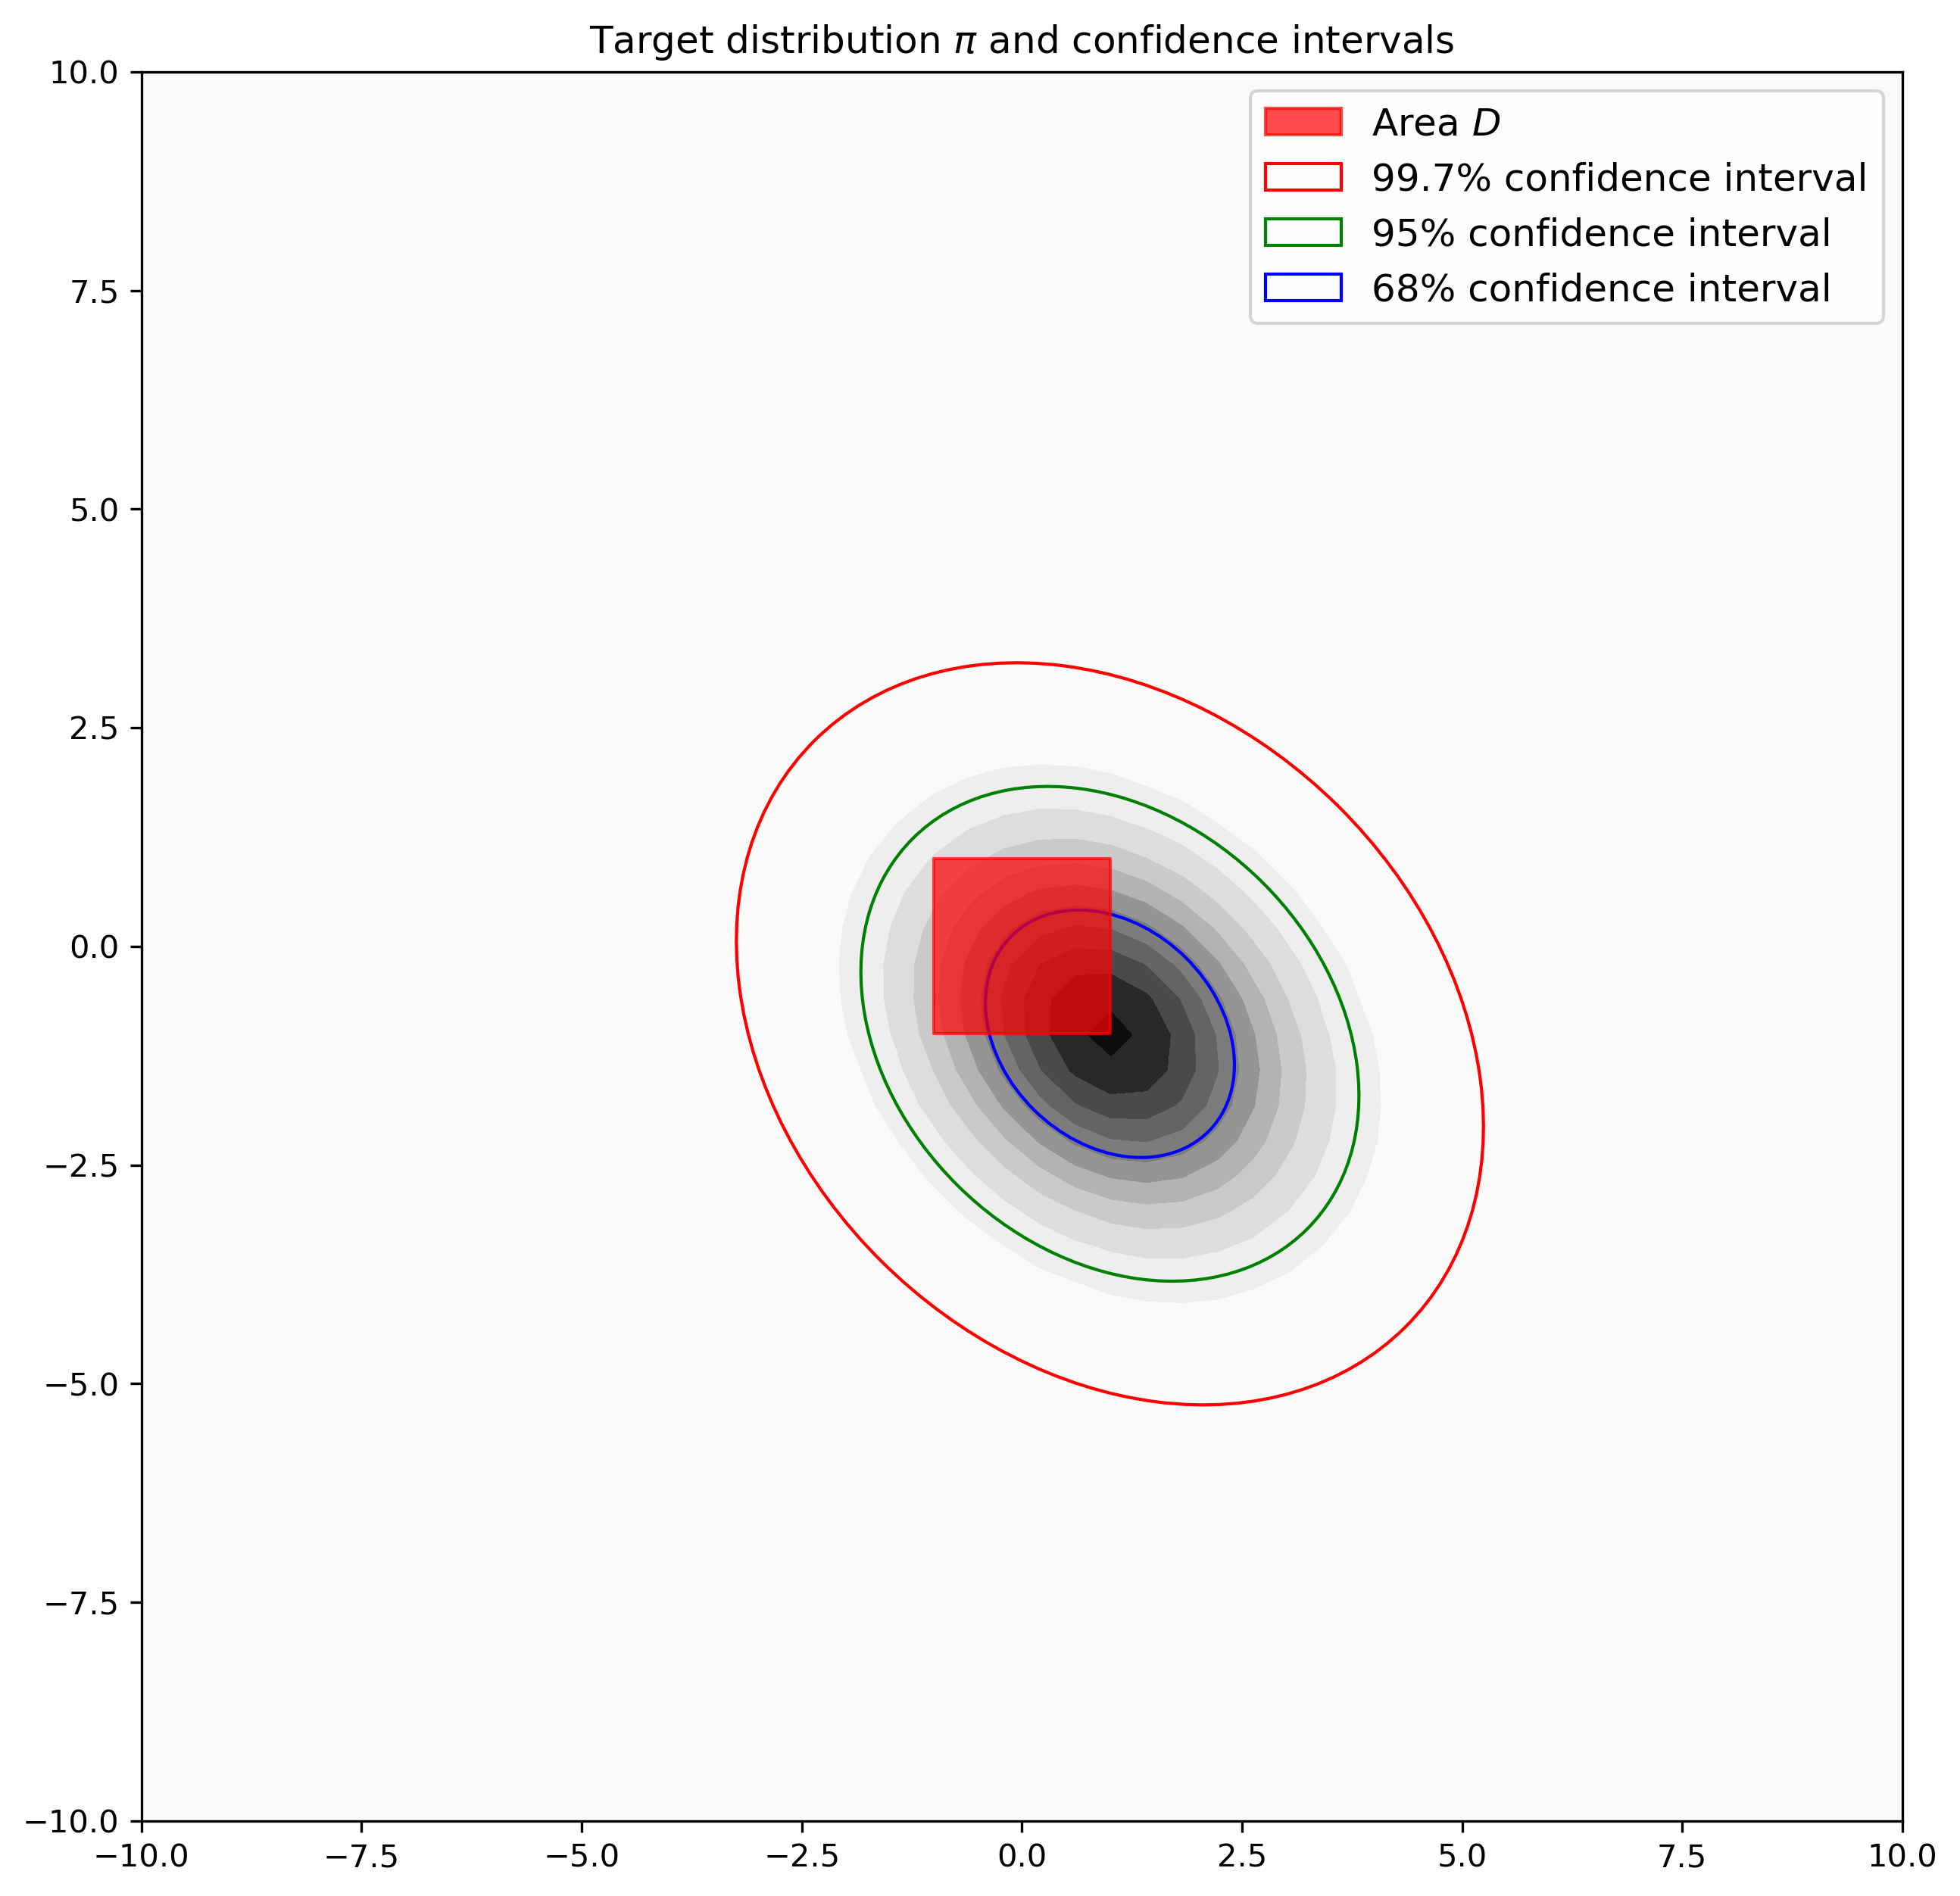

In [293]:
# make figure and ax
fig, ax = plt.subplots(1, 1, figsize=(10,10))
X, Y, Z_pi = fill_z(pi)
ax.contourf(X, Y, Z_pi, levels=10, cmap="Greys", zorder=-10)
ax.fill_between([-1, 1], [-1, -1], [1, 1], color='red', zorder=5, alpha=0.7, label="Area $D$")
pi.construct_ellipse(3, ax, "red", label="99.7% confidence interval")
pi.construct_ellipse(2, ax, "green", label="95% confidence interval")
pi.construct_ellipse(1, ax, "blue", label="68% confidence interval")
ax.legend(loc="upper right", fontsize=12)
ax.set_title("Target distribution $\pi$ and confidence intervals")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show()
fig.savefig("figs/pi_and_D.png", bbox_inches='tight')


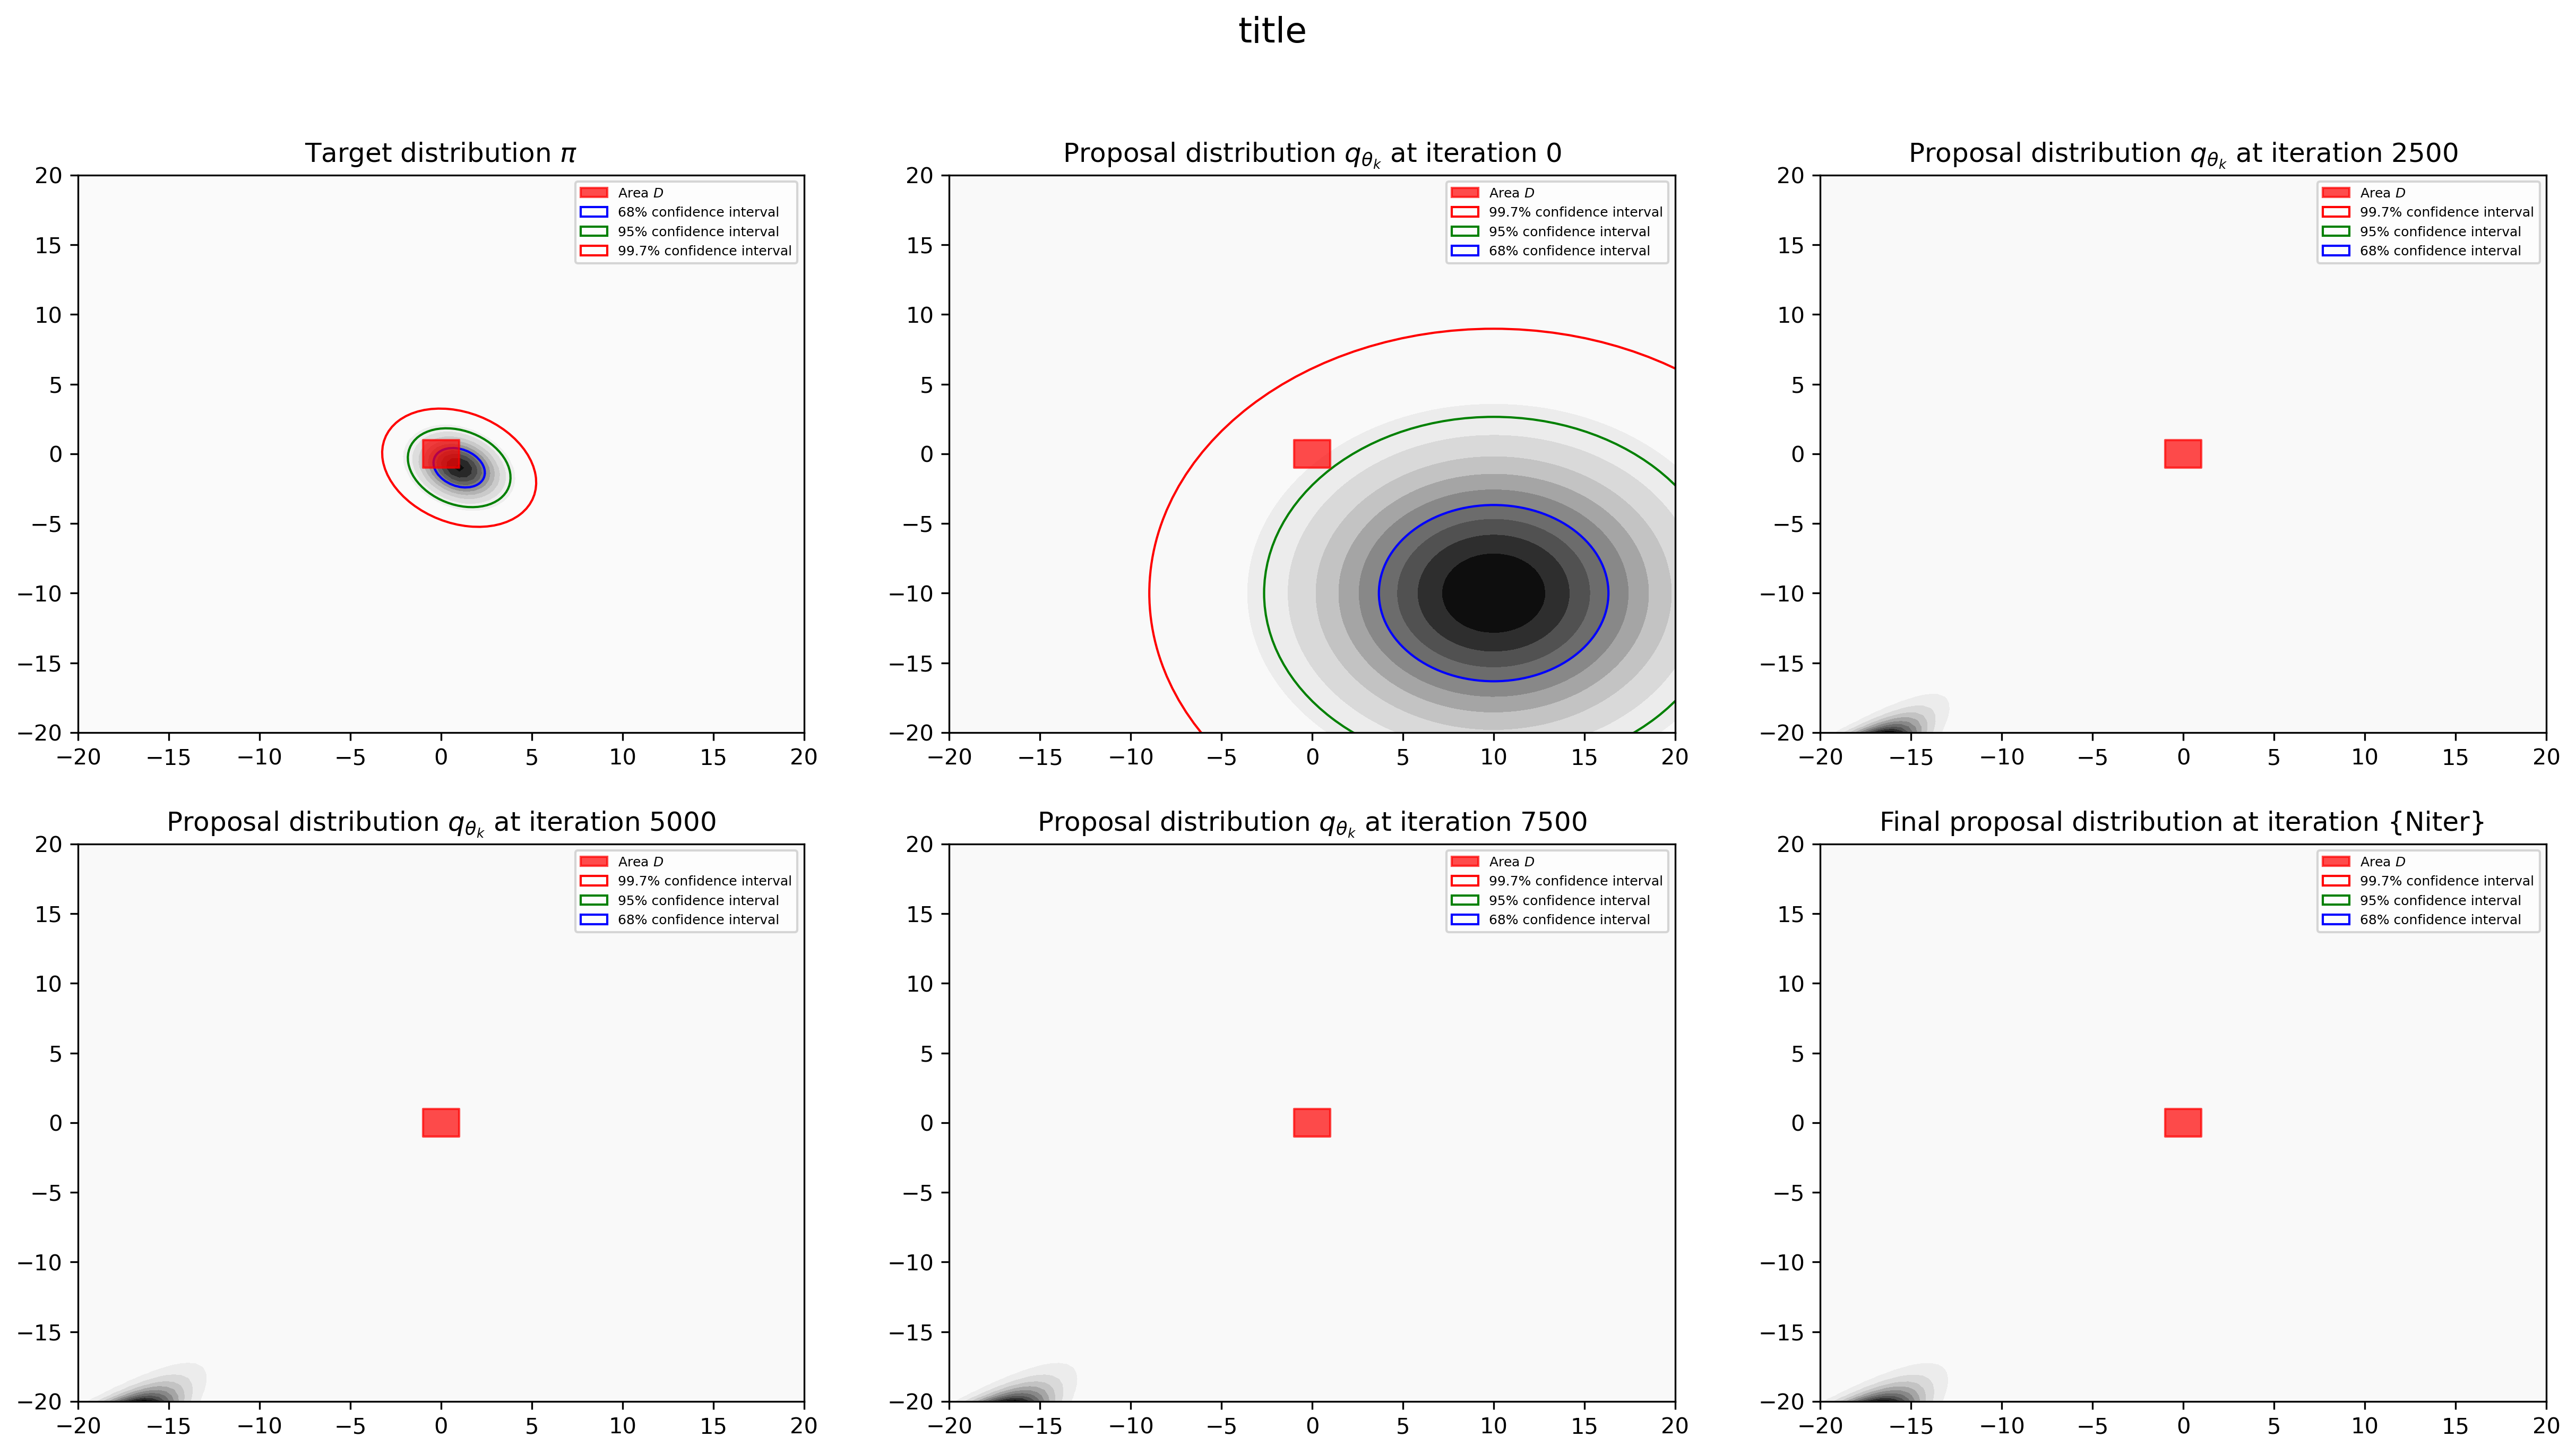

In [18]:
plot_contours(SG_all_distributions, pi, "title")

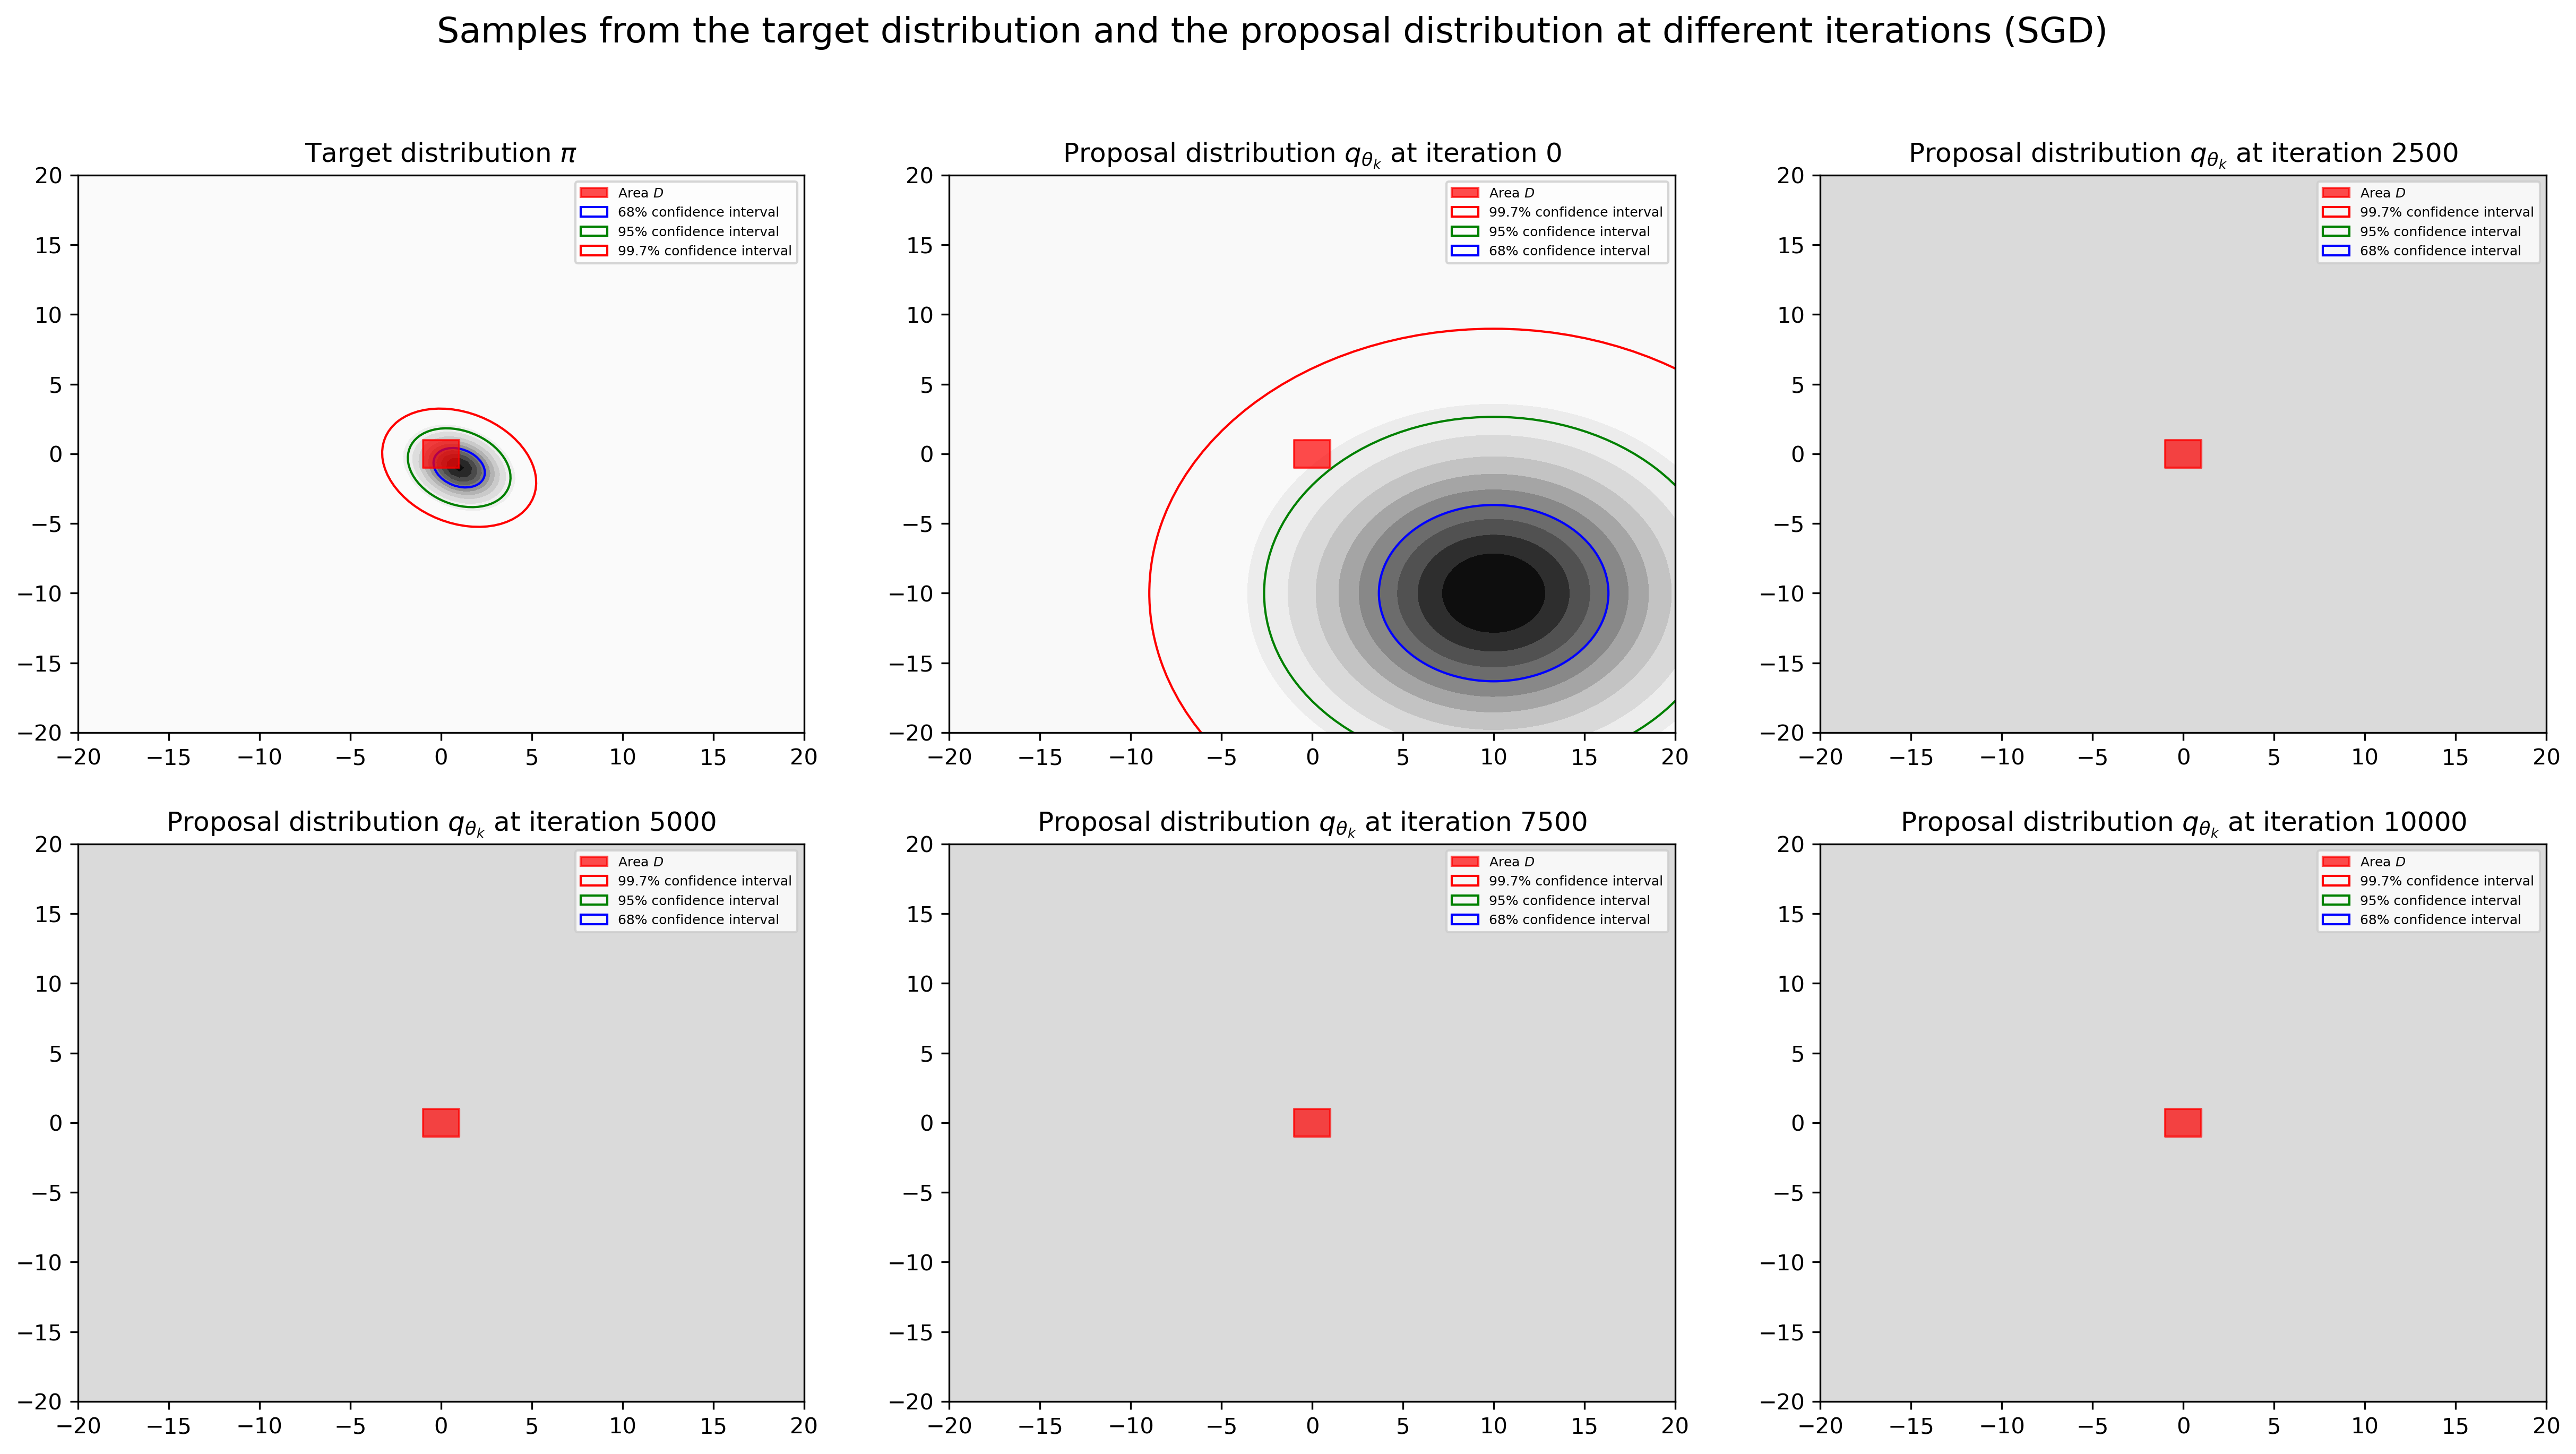

In [294]:
# create 2 by 2 subplots

fig, axs = plt.subplots(2, 3, figsize=(20,10))
#axs[0,0].scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution", zorder=-5)
#axs[0,0].scatter(in_sq[0,:], in_sq[1,:], s=0.1, c='red', label="Samples in the unit square", zorder=-5)
X, Y, Z_pi = fill_z(pi)
axs[0,0].contourf(X, Y, Z_pi, levels=10, cmap="Greys", zorder=-10)
axs[0,0].fill_between([-1, 1], [-1, -1], [1, 1], color='red', zorder=5, alpha=0.7, label="Area $D$")
pi.construct_ellipse(1, axs[0,0], "blue", label="68% confidence interval")
pi.construct_ellipse(2, axs[0,0], "green", label="95% confidence interval")
pi.construct_ellipse(3, axs[0,0], "red", label="99.7% confidence interval")
axs[0,0].legend(loc="upper right", fontsize=6)
axs[0,0].set_xlim(-20, 20)
axs[0,0].set_ylim(-20, 20)
axs[0,0].set_title("Target distribution $\pi$")

remaining_axs = [axs[0,1],axs[0,2],axs[1,0],axs[1,1], axs[1,2]]

for i, ax in zip(dist_to_get, remaining_axs):
    #ax.scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution", zorder=-5)
    ax.fill_between([-1, 1], [-1, -1], [1, 1], color='red', zorder=5, alpha=0.7, label="Area $D$")
    X, Y, Z_d = fill_z(SG_average_distributions[i])
    ax.contourf(X, Y, Z_d, levels=10, cmap="Greys", zorder=-10)

    SG_average_distributions[i].construct_ellipse(3, ax, "red", label="99.7% confidence interval")
    SG_average_distributions[i].construct_ellipse(2, ax, "green" , label="95% confidence interval")
    SG_average_distributions[i].construct_ellipse(1, ax, "blue", label="68% confidence interval")
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.legend(loc="upper right", fontsize=6)
    str_mid = "$q_{\\theta_k}$"
    ax.set_title("Proposal distribution " + str_mid +  " at iteration {}".format(i))

fig.suptitle("Samples from the target distribution and the proposal distribution at different iterations (SGD)", fontsize=16)
fig.tight_layout
plt.show()

---

# Plots for Adam

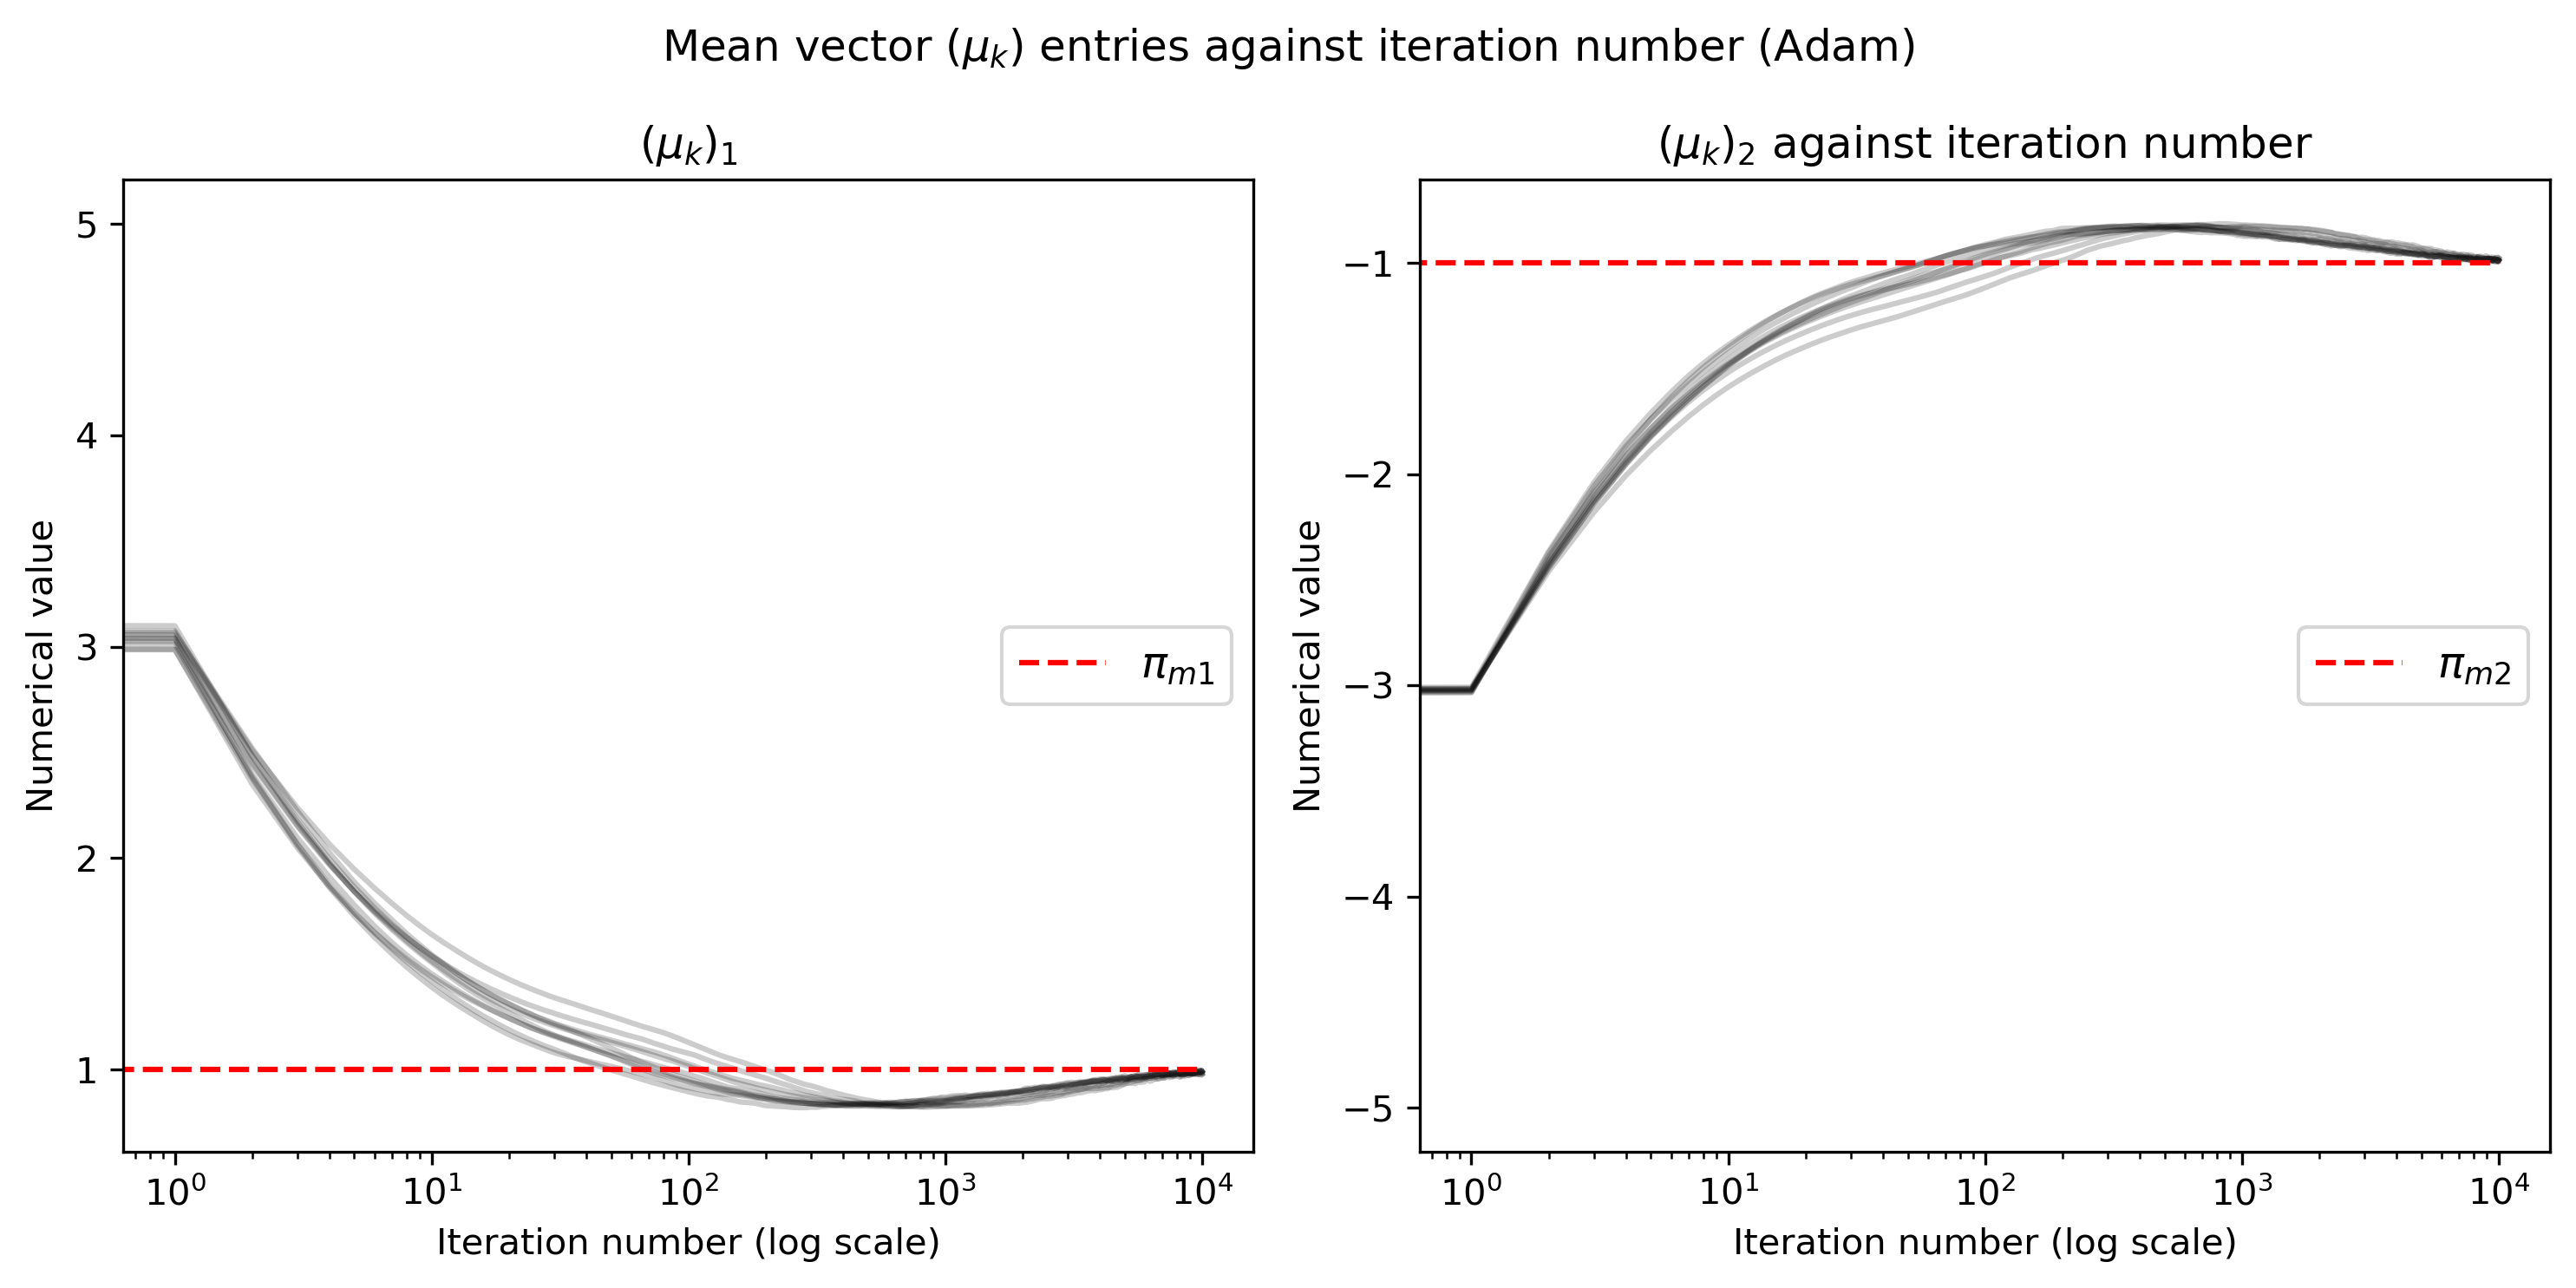

In [278]:
#mu1 = [average_distributions[i].mu[0] for i in range(0, Niter)]
#mu2 = [average_distributions[i].mu[1] for i in range(0, Niter)]

# make 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.plot(mu1, label="$(\mu_k)_1$", color="black")
for i, distribution_list in enumerate(ADAM_all_distributions):
    mu_1 = [d.mu[0] for d in distribution_list]
    mu_2 = [d.mu[1] for d in distribution_list]
    ax1.plot(mu_1, color="black", alpha=0.2)
    ax2.plot(mu_2, color="black", alpha=0.2)
ax1.hlines(pi.mu[0], 0, Niter, label="$\pi_{m1}$", color="red", linestyle="--")
ax1.legend(loc="center right", fontsize=12)
ax1.set_xlabel("Iteration number (log scale)")
ax1.set_ylabel("Numerical value")
ax1.set_title("$(\mu_k)_1$")
ax1.set_xscale("log")

#ax2.plot(mu2, label="$(\mu_k)_2$", color="black")
ax2.set_xscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Iteration number (log scale)")
ax2.set_ylabel("Numerical value")
ax2.set_title("$(\mu_k)_2$ against iteration number")
ax2.hlines(pi.mu[1], 0, Niter, label="$\pi_{m2}$", color="red", linestyle="--")
ax2.legend(loc="center right", fontsize=12)
fig.suptitle("Mean vector $(\mu_k)$ entries against iteration number (Adam)")
fig.tight_layout()
plt.show()

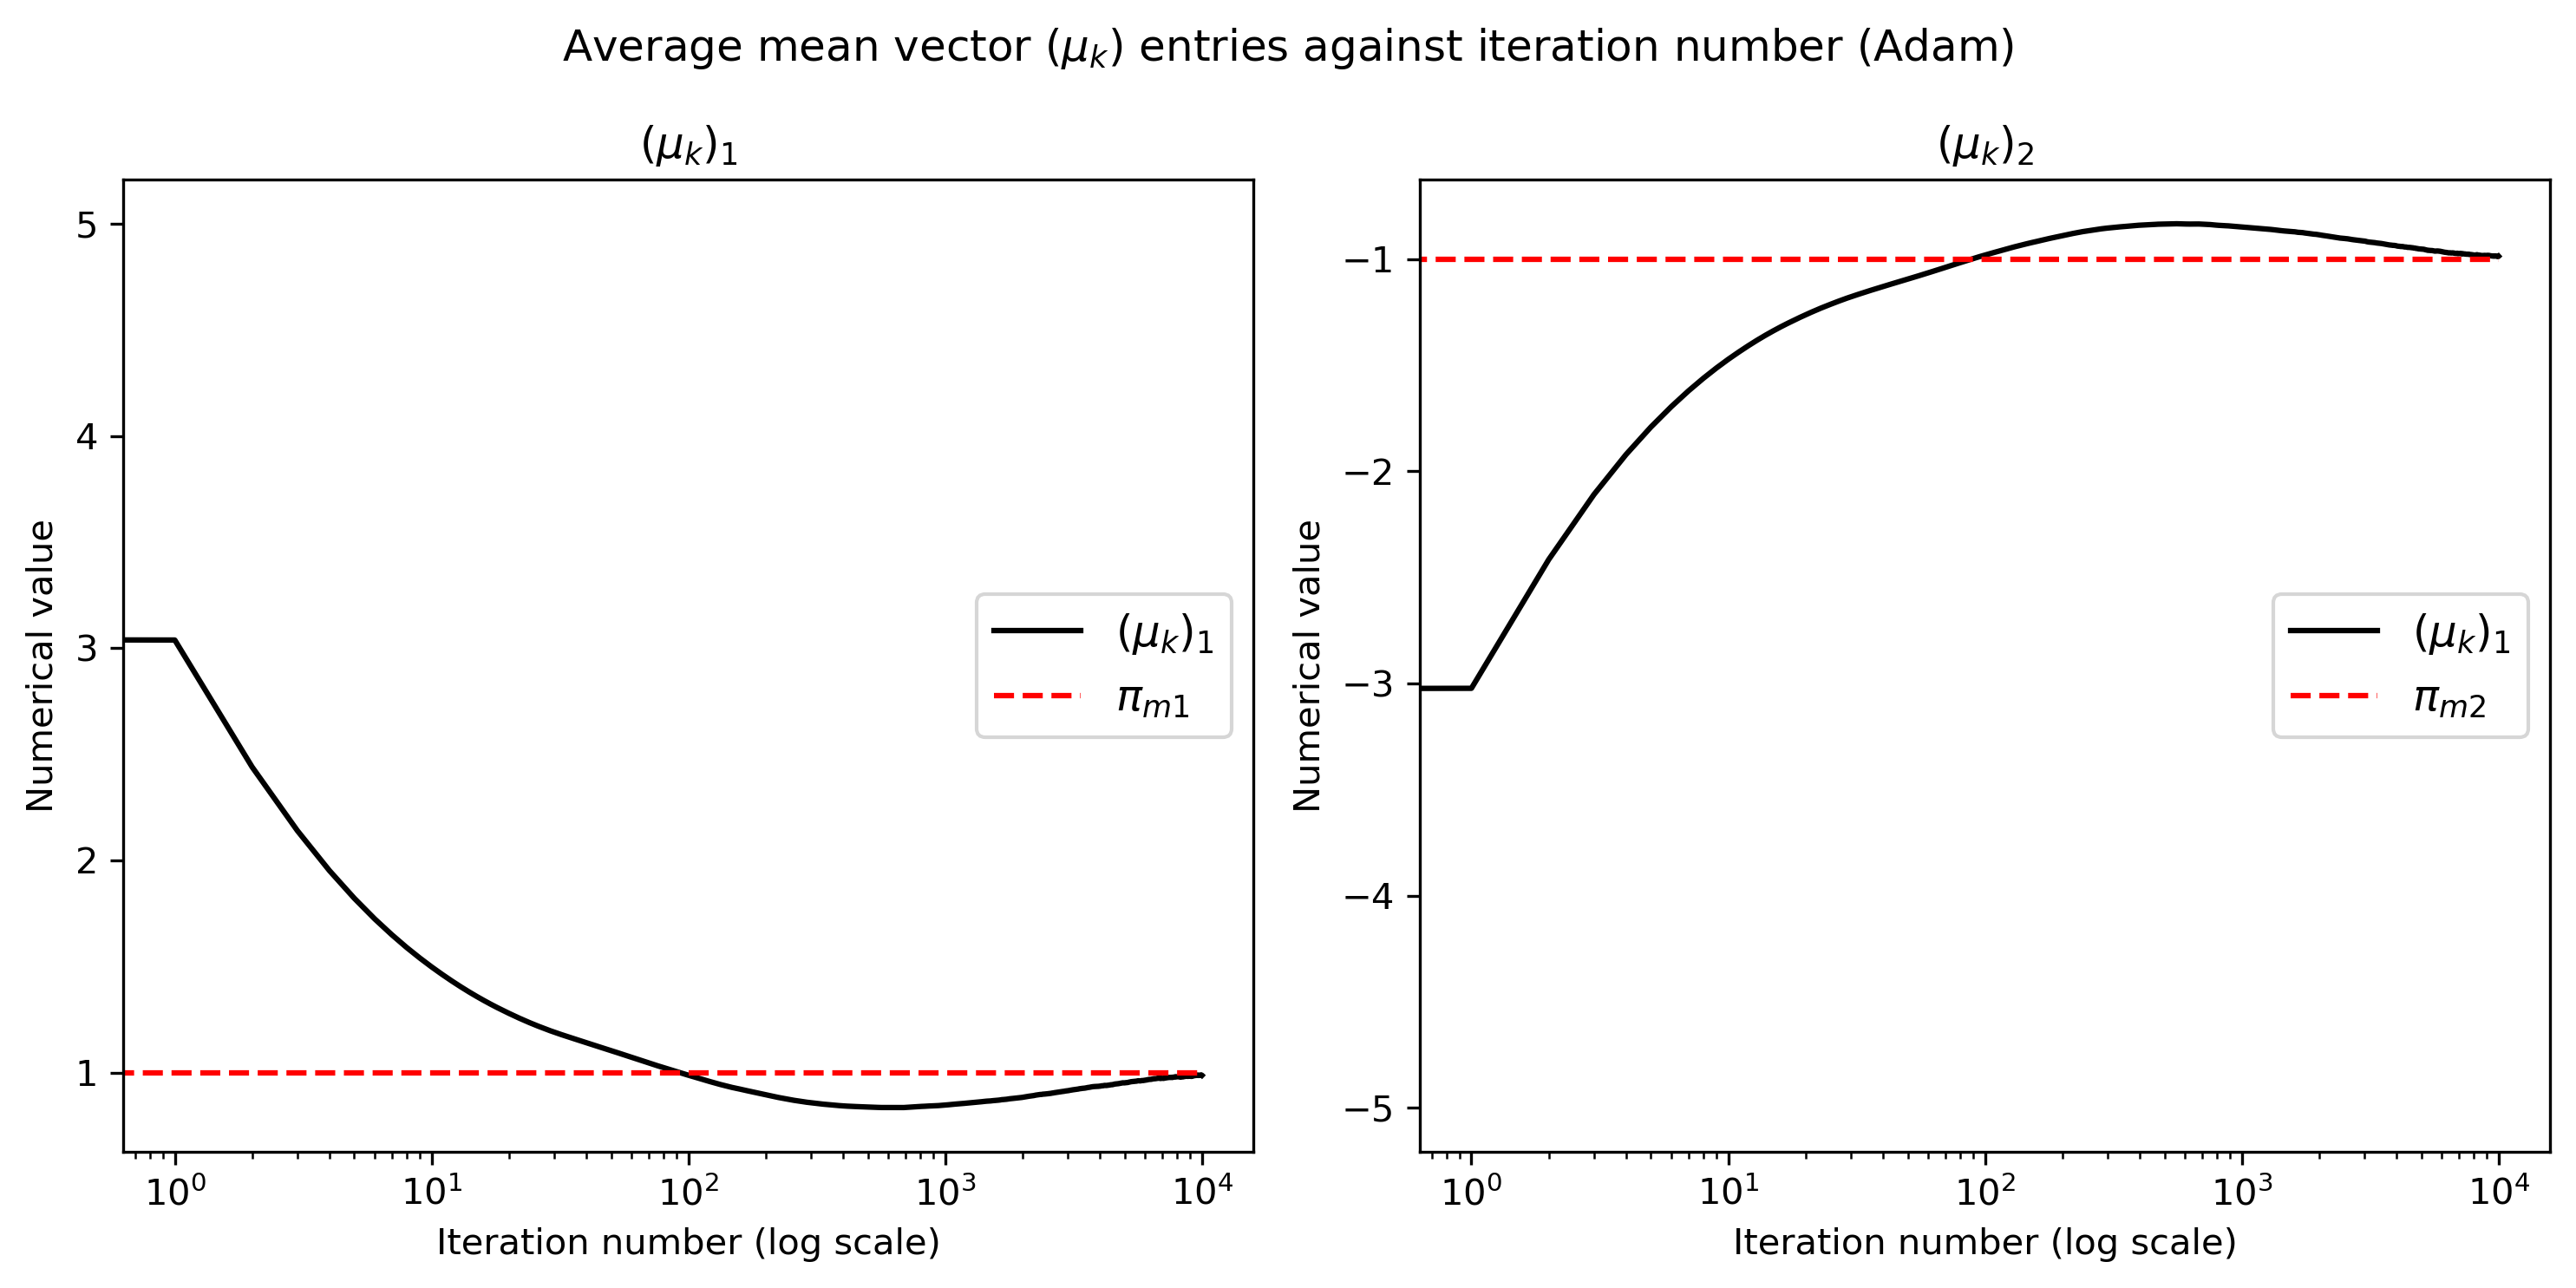

In [279]:
#mu1 = [average_distributions[i].mu[0] for i in range(0, Niter)]
#mu2 = [average_distributions[i].mu[1] for i in range(0, Niter)]

# make 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.plot(mu1, label="$(\mu_k)_1$", color="black")
ax1.plot([d.mu[0] for d in ADAM_average_distributions], label="$(\mu_k)_1$", color="black")
ax1.hlines(pi.mu[0], 0, Niter, label="$\pi_{m1}$", color="red", linestyle="--")
ax1.legend(loc="center right", fontsize=12)
ax1.set_xlabel("Iteration number (log scale)")
ax1.set_ylabel("Numerical value")
ax1.set_title("$(\mu_k)_1$")
ax1.set_xscale("log")

#ax2.plot(mu2, label="$(\mu_k)_2$", color="black")
ax2.plot([d.mu[1] for d in ADAM_average_distributions], label="$(\mu_k)_1$", color="black")
ax2.set_xscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Iteration number (log scale)")
ax2.set_ylabel("Numerical value")
ax2.set_title("$(\mu_k)_2$")
ax2.hlines(pi.mu[1], 0, Niter, label="$\pi_{m2}$", color="red", linestyle="--")
ax2.legend(loc="center right", fontsize=12)
fig.suptitle("Average mean vector $(\mu_k)$ entries against iteration number (Adam)")
fig.tight_layout()
plt.show()

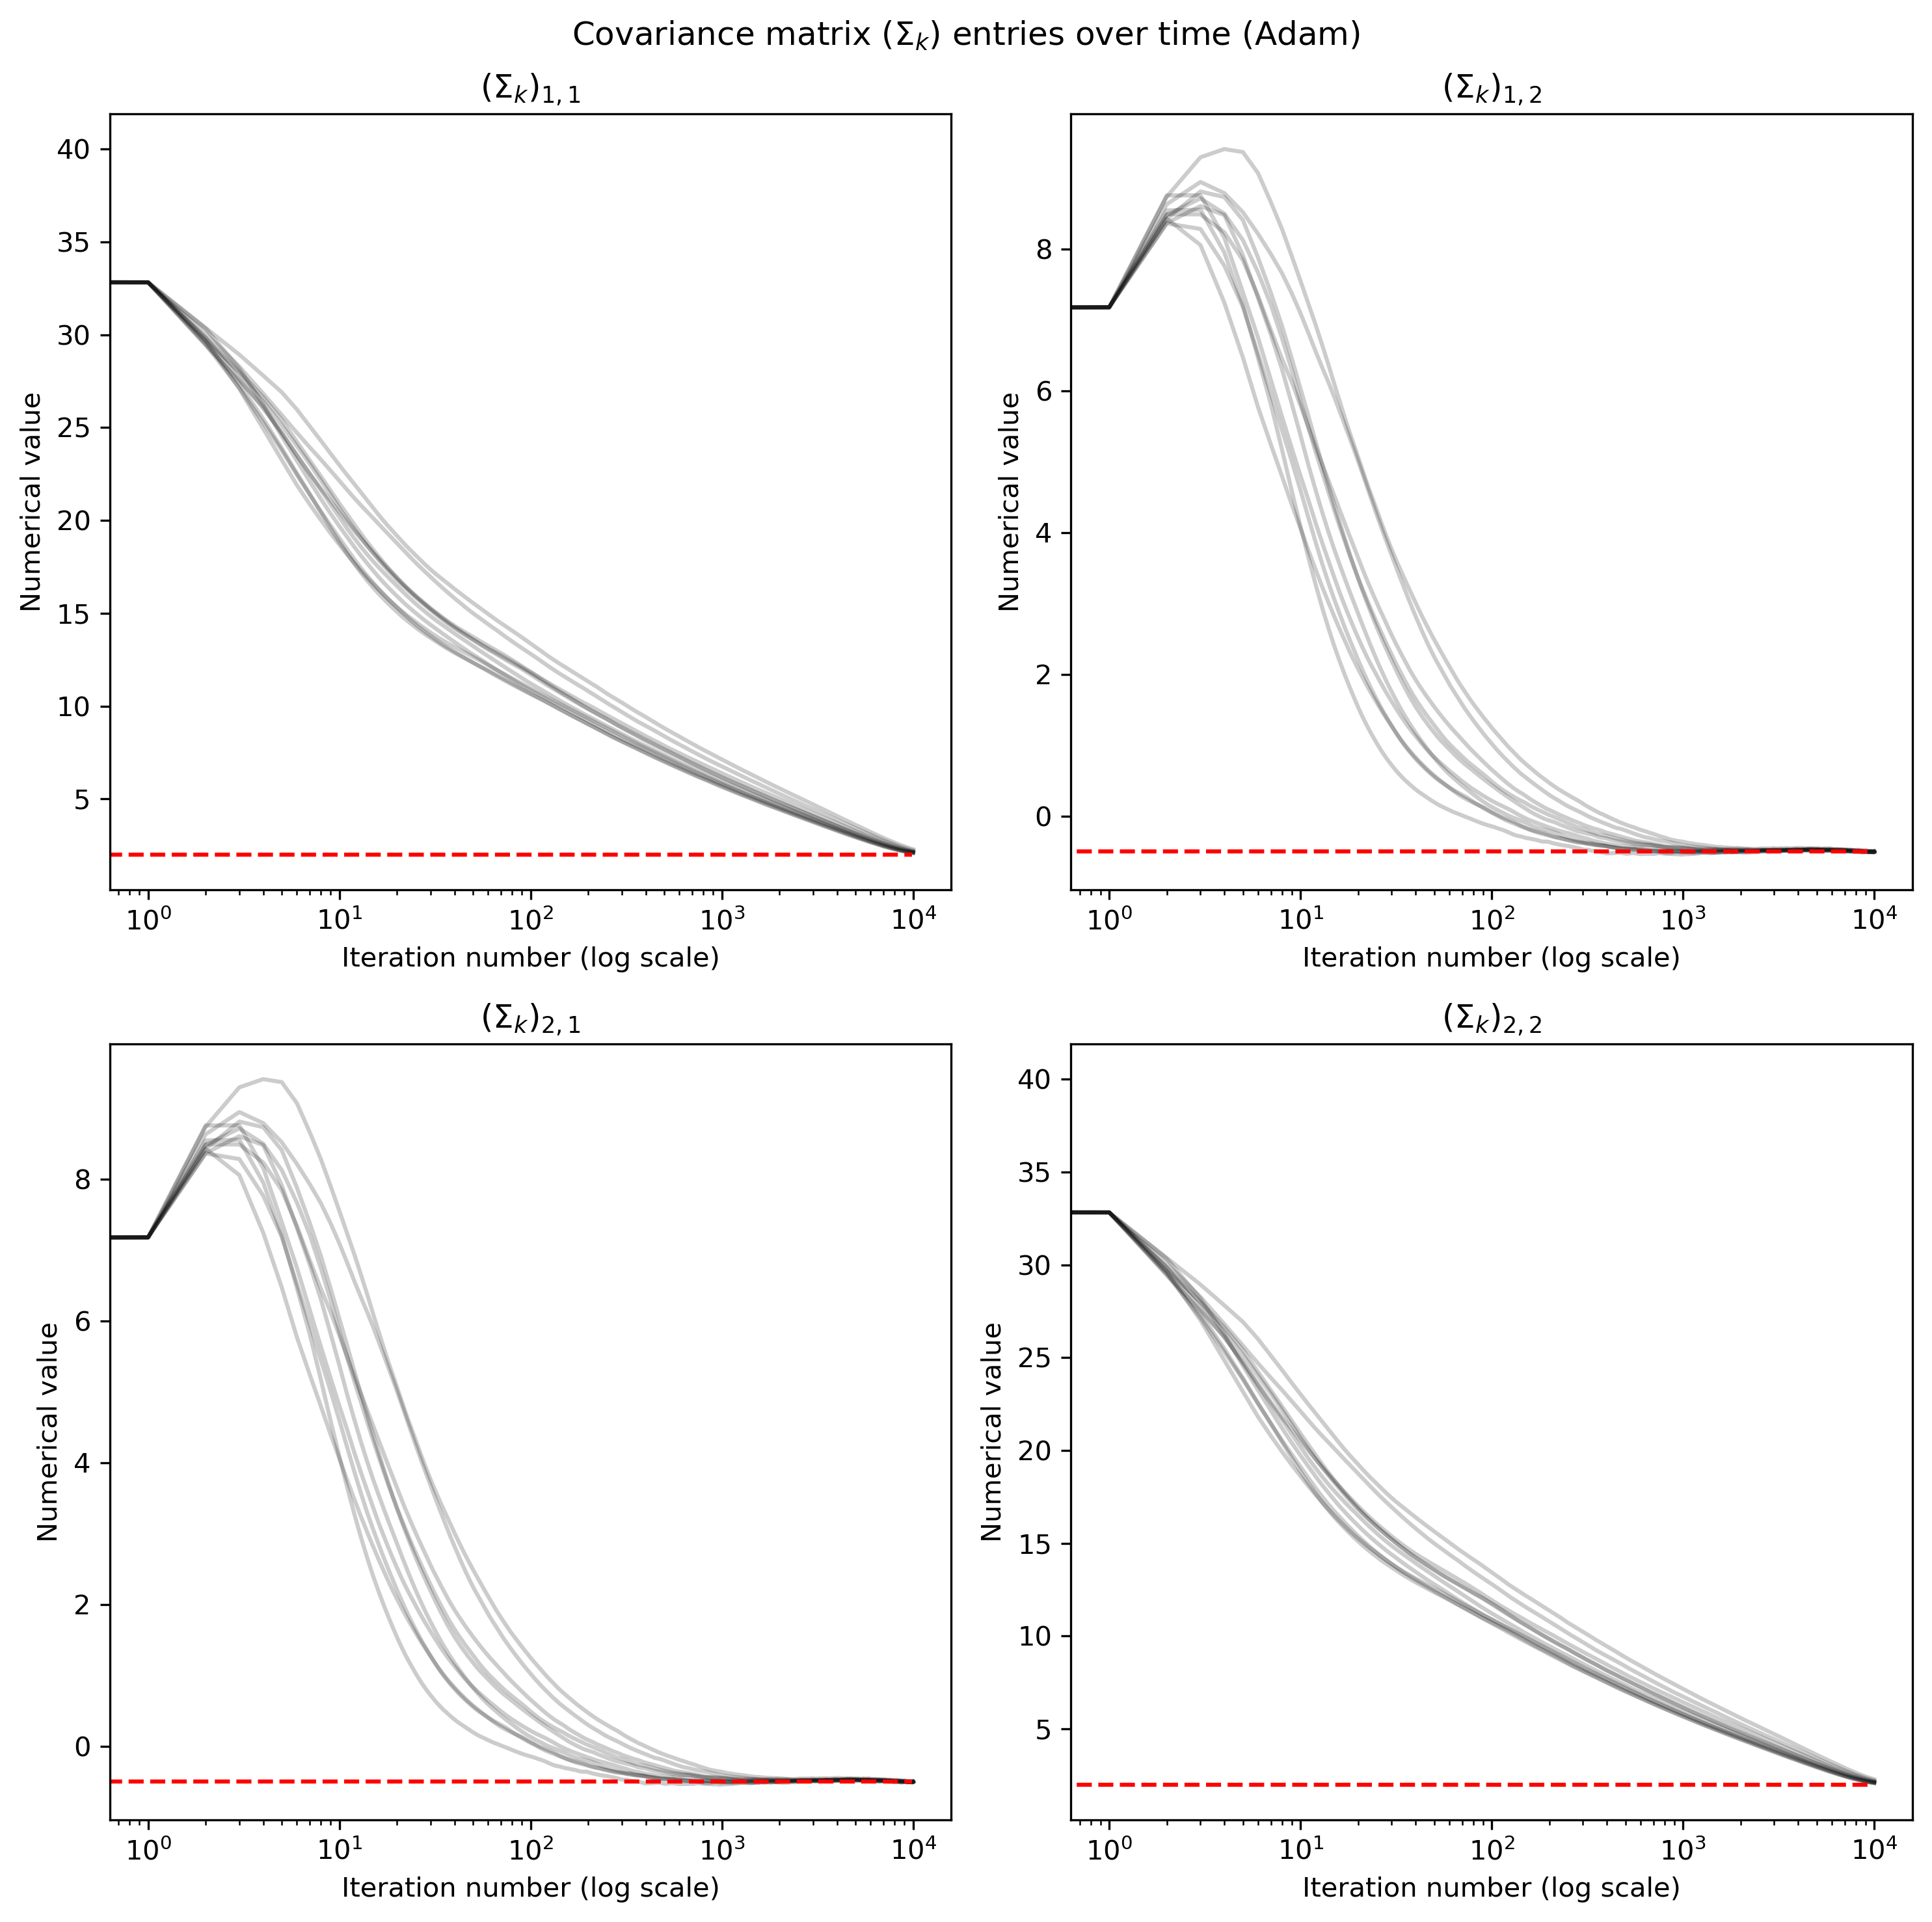

In [280]:
#sigma00 = [distributions[i].Sigma[0][0] for i in range(0, Niter)]
#sigma11 = [distributions[i].Sigma[1][1] for i in range(0, Niter)]
#sigma01 = [distributions[i].Sigma[0][1] for i in range(0, Niter)]
#sigma10 = [distributions[i].Sigma[1][0] for i in range(0, Niter)]
true = pi.Sigma
true00 = true[0][0]
true11 = true[1][1]
true01 = true[0][1]
true10 = true[1][0]
# make 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, distribution_list in enumerate(ADAM_all_distributions):
    sigma00 = [d.Sigma[0][0] for d in distribution_list]
    sigma10 = [d.Sigma[1][0] for d in distribution_list]
    sigma01 = [d.Sigma[0][1] for d in distribution_list]
    sigma11 = [d.Sigma[1][1] for d in distribution_list]
    axs[0, 0].plot(sigma00, color="black", alpha=0.2)
    axs[1, 0].plot(sigma10, color="black", alpha=0.2)
    axs[0, 1].plot(sigma01, color="black", alpha=0.2)
    axs[1, 1].plot(sigma11, color="black", alpha=0.2)

axs[0, 0].hlines(y=true00, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 0].set_title('$(\Sigma_k)_{1,1}$')
axs[0, 1].hlines(y=true01, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 1].set_title('$(\Sigma_k)_{1,2}$')
axs[1, 0].hlines(y=true10, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 0].set_title('$(\Sigma_k)_{2,1}$')
axs[1, 1].hlines(y=true11, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 1].set_title('$(\Sigma_k)_{2,2}$')
for ax in axs.flat:
    #ax.set(xlabel='iteration (log scale)', ylabel='sigma')
    # set x-axis to log scale
    ax.set_xscale('log')
    ax.set_xlabel("Iteration number (log scale)")
    ax.set_ylabel("Numerical value")
fig.suptitle('Covariance matrix $(\Sigma_k)$ entries over time (Adam)')
fig.tight_layout()
plt.show()
# plot entries of the covariance matrix

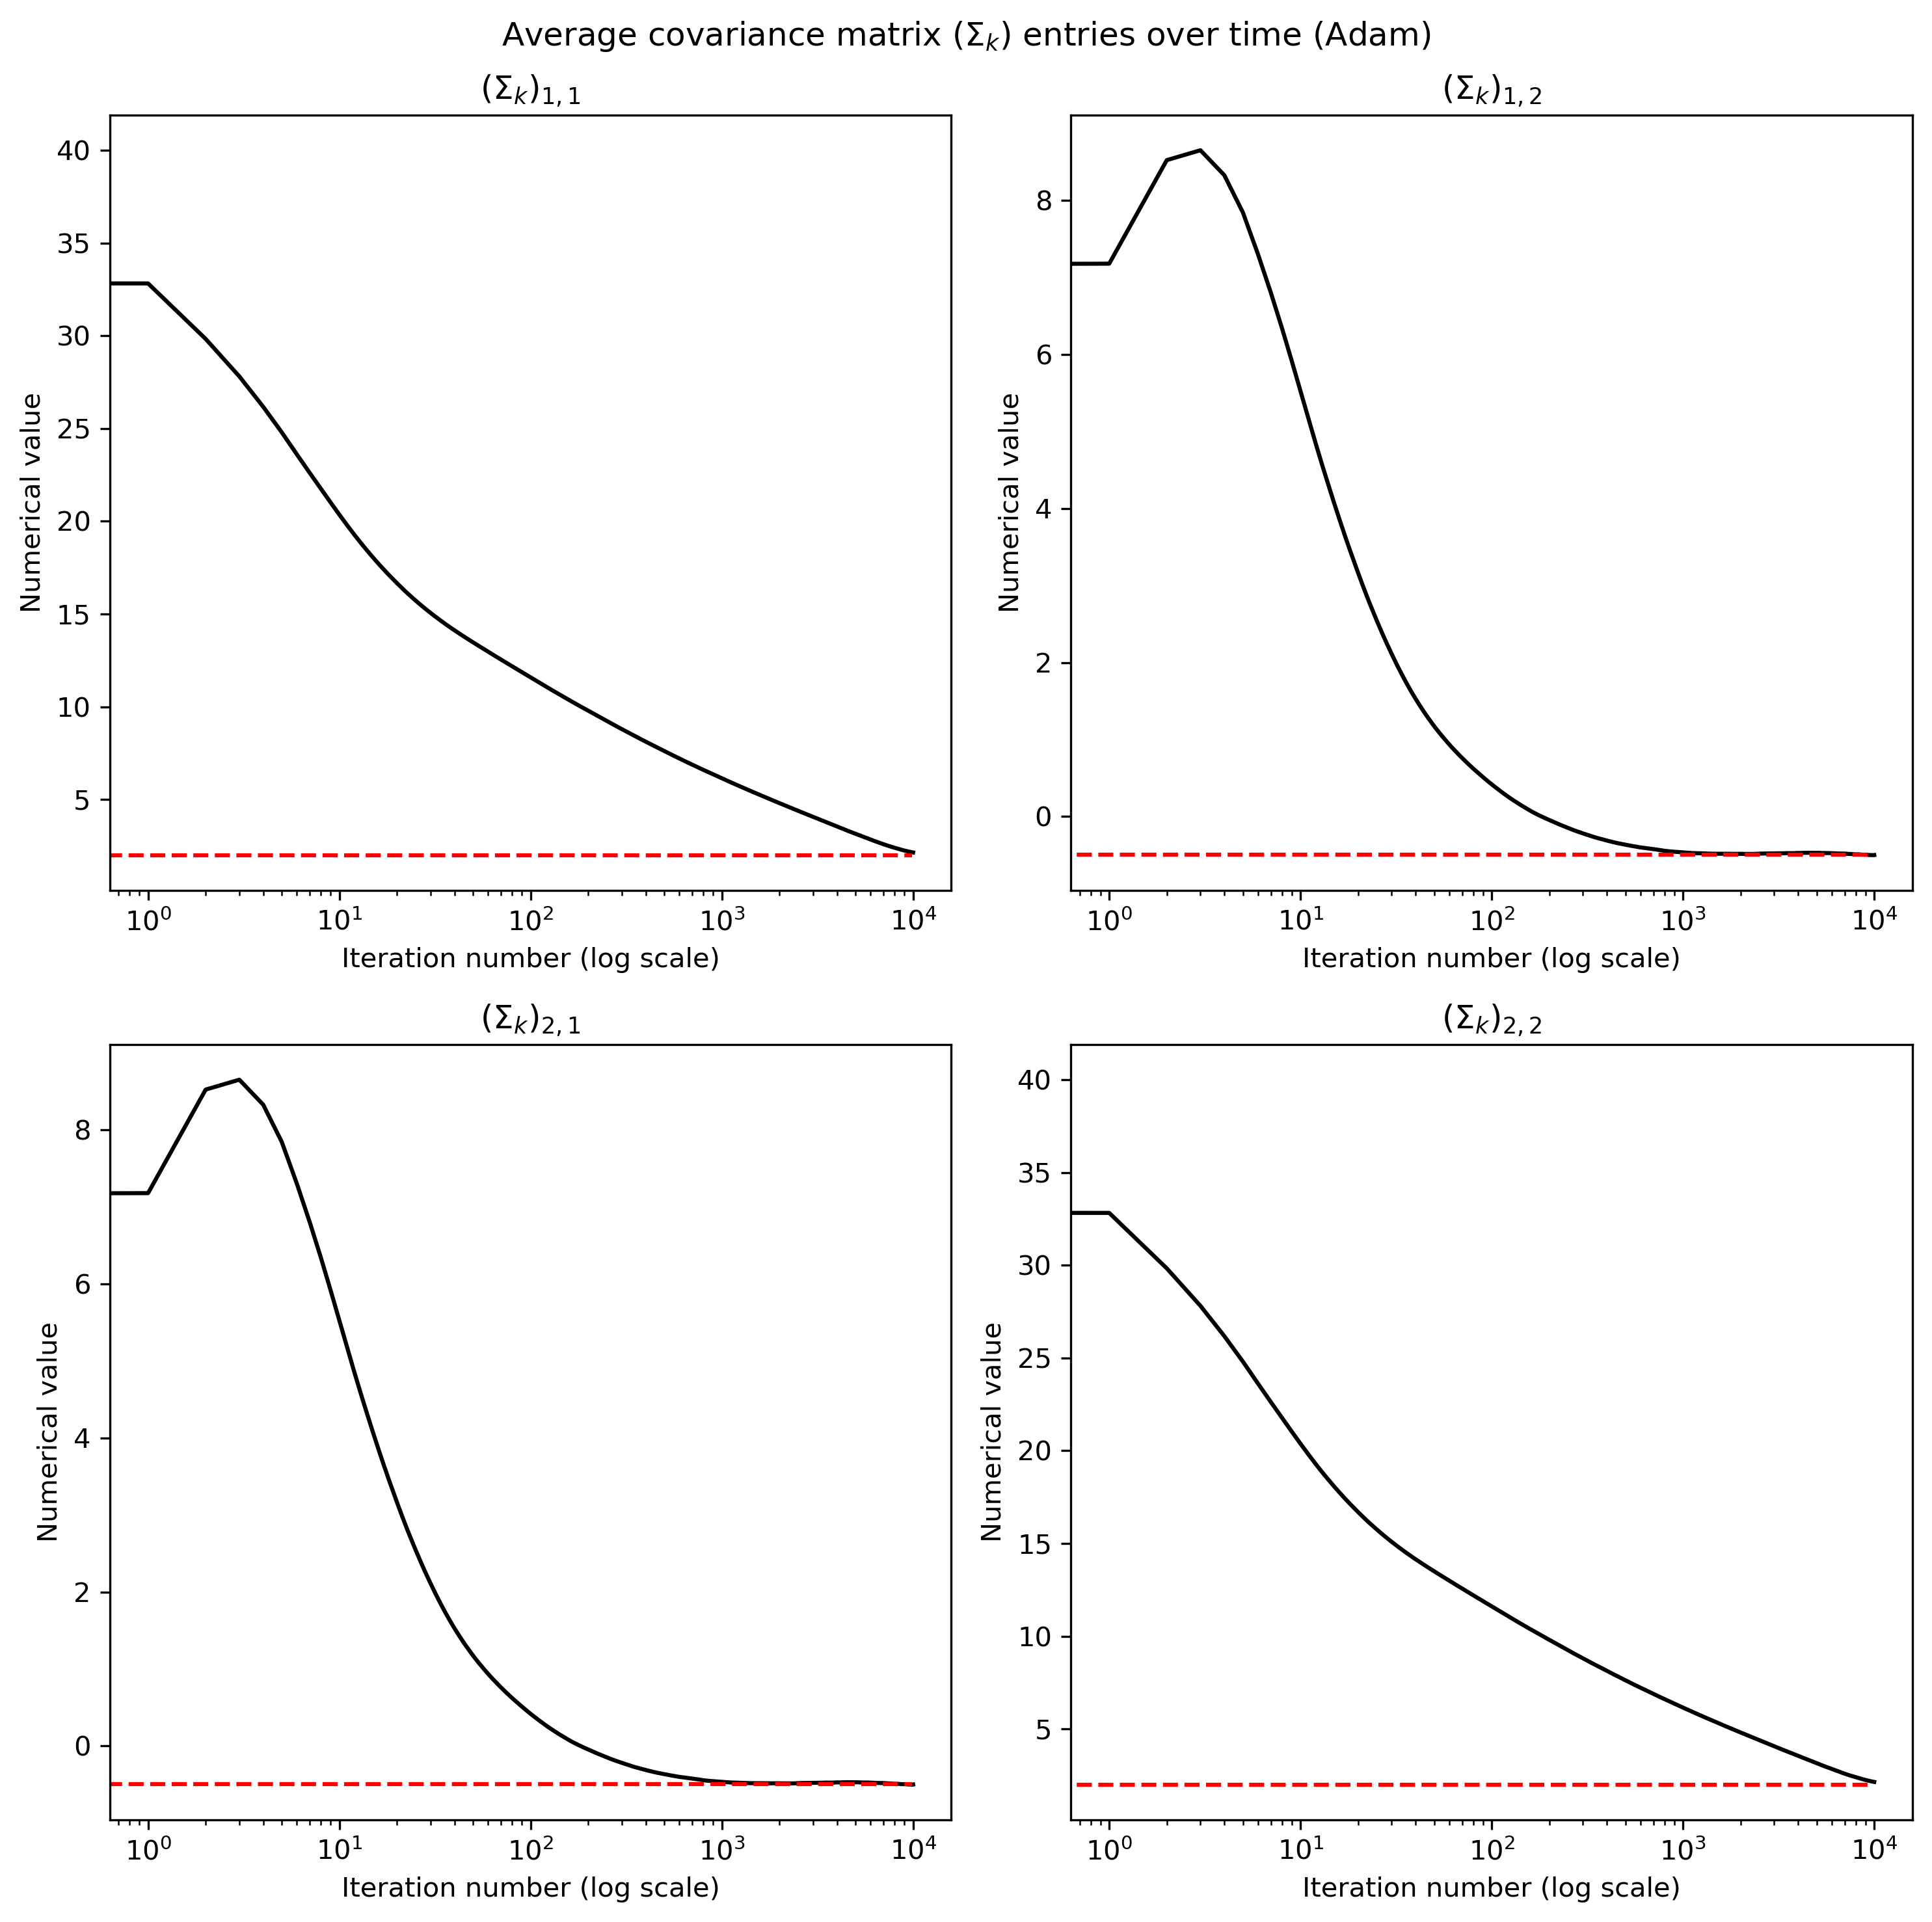

In [281]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

sigma00 = [d.Sigma[0][0] for d in ADAM_average_distributions]
sigma10 = [d.Sigma[1][0] for d in ADAM_average_distributions]
sigma01 = [d.Sigma[0][1] for d in ADAM_average_distributions]
sigma11 = [d.Sigma[1][1] for d in ADAM_average_distributions]
axs[0, 0].plot(sigma00, color="black")
axs[1, 0].plot(sigma10, color="black")
axs[0, 1].plot(sigma01, color="black")
axs[1, 1].plot(sigma11, color="black")

axs[0, 0].hlines(y=true00, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 0].set_title('$(\Sigma_k)_{1,1}$')
axs[0, 1].hlines(y=true01, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[0, 1].set_title('$(\Sigma_k)_{1,2}$')
axs[1, 0].hlines(y=true10, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 0].set_title('$(\Sigma_k)_{2,1}$')
axs[1, 1].hlines(y=true11, color='r', linestyle='--', xmin=0, xmax=Niter-100)
axs[1, 1].set_title('$(\Sigma_k)_{2,2}$')
for ax in axs.flat:
    #ax.set(xlabel='iteration (log scale)', ylabel='sigma')
    # set x-axis to log scale
    ax.set_xscale('log')
    ax.set_xlabel("Iteration number (log scale)")
    ax.set_ylabel("Numerical value")
fig.suptitle('Average covariance matrix $(\Sigma_k)$ entries over time (Adam)')
fig.tight_layout()
plt.show()
# plot entries of the covariance matrix

In [282]:
pi

N([ 1 -1], [[ 2.  -0.5]
 [-0.5  2. ]])

In [160]:
ADAM_average_distributions[-1]

N([ 0.9193448  -0.91711526], [[ 3.88009261 -0.32187786]
 [-0.32187786  3.90802708]])

TypeError: Input z must be 2D, not 3D

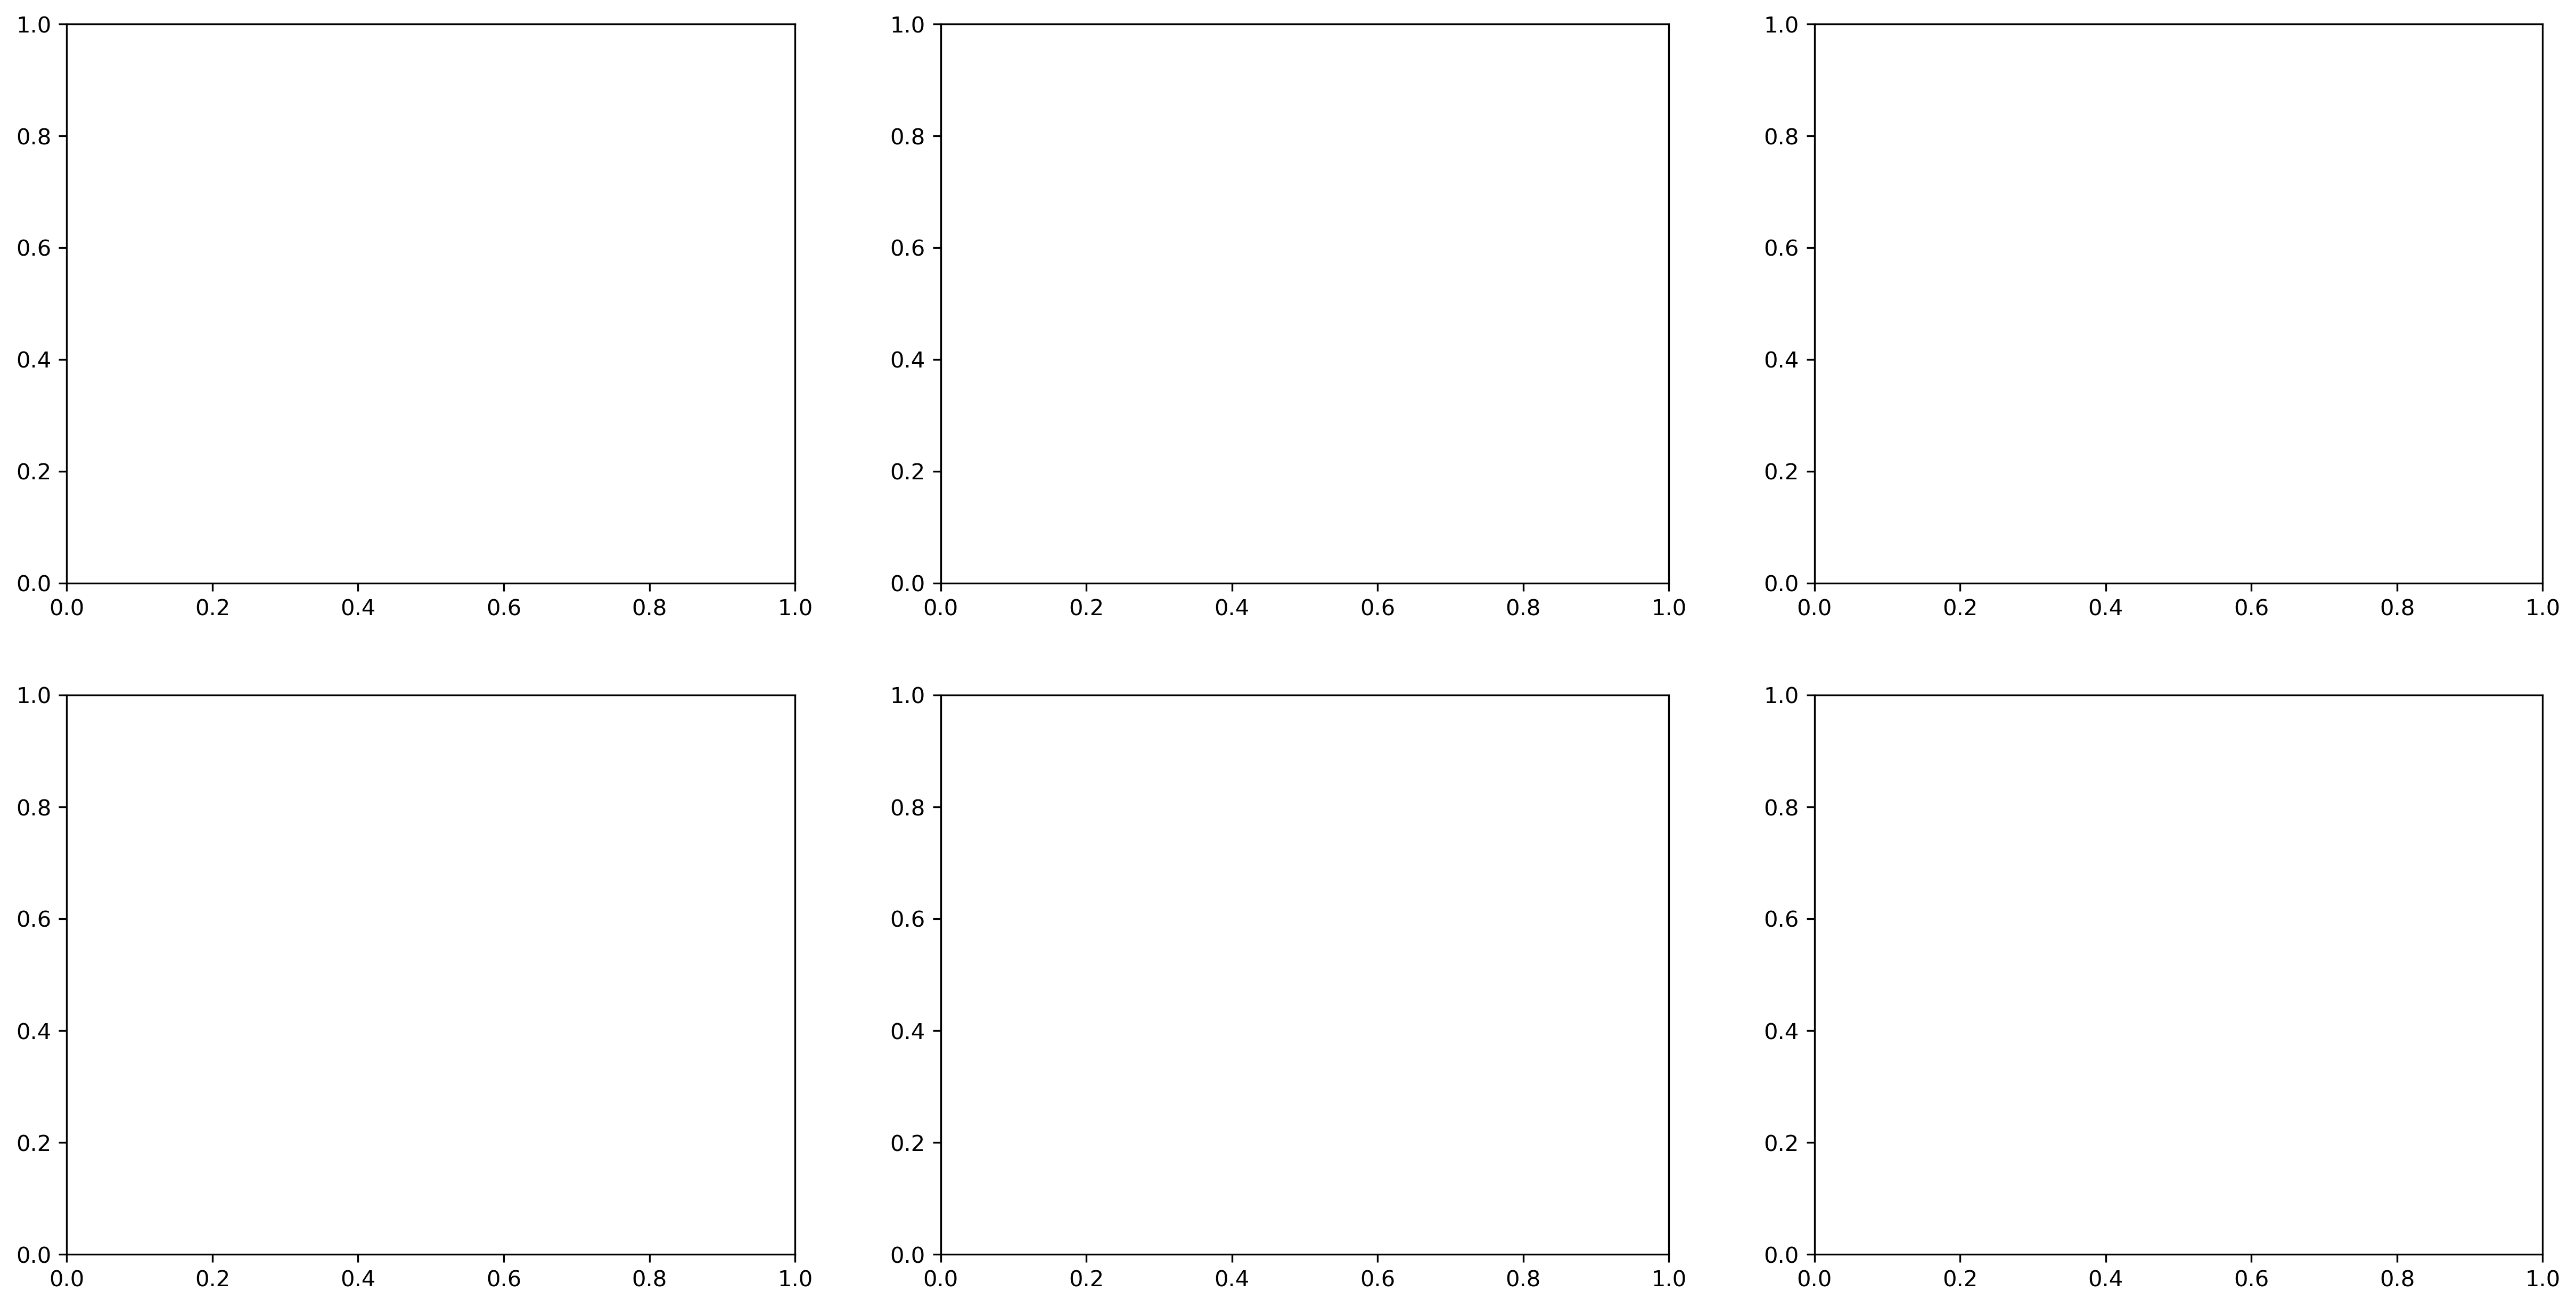

In [247]:
# create 2 by 2 subplots
fig, axs = plt.subplots(2, 3, figsize=(20,10))
#axs[0,0].scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution", zorder=-5)
#axs[0,0].scatter(in_sq[0,:], in_sq[1,:], s=0.1, c='red', label="Samples in the unit square", zorder=-5)
Z_pi = fill_z(pi)
axs[0,0].contourf(X, Y, Z_pi, levels=10, cmap="Greys", zorder=-10)
axs[0,0].fill_between([-1, 1], [-1, -1], [1, 1], color='red', zorder=5, alpha=0.7, label="Area $D$")
pi.construct_ellipse(1, axs[0,0], "blue", label="68% confidence interval")
pi.construct_ellipse(2, axs[0,0], "green", label="95% confidence interval")
pi.construct_ellipse(3, axs[0,0], "red", label="99.7% confidence interval")
axs[0,0].legend(loc="upper right", fontsize=6)
axs[0,0].set_xlim(-20, 20)
axs[0,0].set_ylim(-20, 20)
axs[0,0].set_title("Target distribution $\pi$")

remaining_axs = [axs[0,1],axs[0,2],axs[1,0],axs[1,1], axs[1,2]]

for i, ax in zip(dist_to_get, remaining_axs):
    #ax.scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution", zorder=-5)
    ax.fill_between([-1, 1], [-1, -1], [1, 1], color='red', zorder=5, alpha=0.7, label="Area $D$")
    Z_d = fill_z(ADAM_average_distributions[i])
    ax.contourf(X, Y, Z_d, levels=10, cmap="Greys", zorder=-10)

    ADAM_average_distributions[i].construct_ellipse(3, ax, "red", label="99.7% confidence interval")
    ADAM_average_distributions[i].construct_ellipse(2, ax, "green" , label="95% confidence interval")
    ADAM_average_distributions[i].construct_ellipse(1, ax, "blue", label="68% confidence interval")
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.legend(loc="upper right", fontsize=6)
    str_mid = "$q_{\\theta_k}$"
    ax.set_title("Proposal distribution " + str_mid +  " at iteration {}".format(i))

fig.suptitle("Target and average proposal distribution at different iterations (ADAM)", fontsize=16)
fig.tight_layout
plt.show()

---

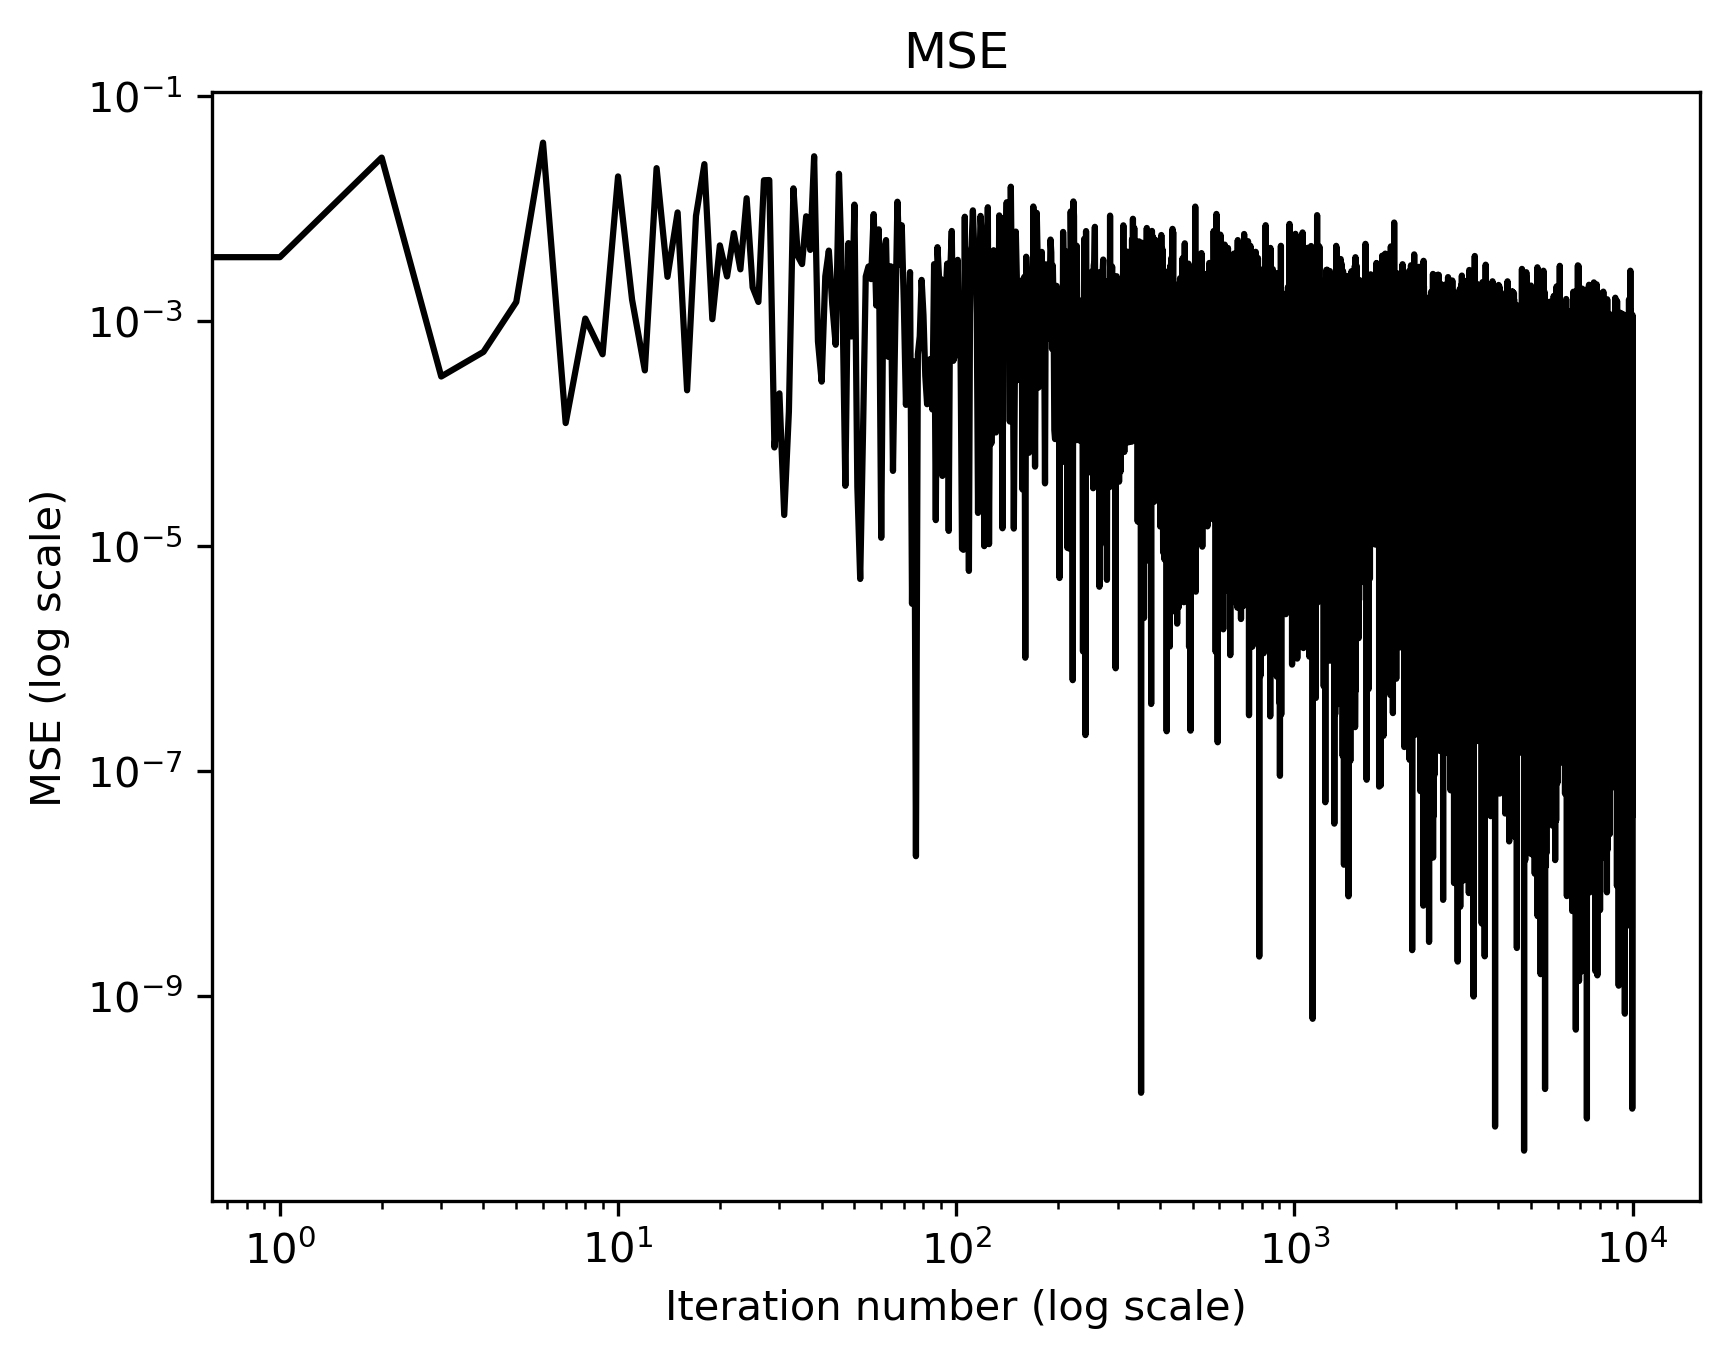

In [291]:
mse_err = (SG_averaged_results-GT)**2
plt.plot(mse_err, color = "black")
plt.title("MSE (SGD)")
plt.xlabel("Iteration number (log scale)")
plt.xscale("log")

plt.ylabel("MSE (log scale)")
plt.yscale("log")
plt.show()



Another measure of computing how close two probability distributions are is through the Kullbacl-Liebler (KL) divergence. Given two probability distributions $P$ and $Q$, the formula for KL divergence is:

$$
KL(P||Q) = \int_{\mathbb{R}^n}p(x)\log\frac{p(x)}{q(x)}dx
$$

For $P,\, Q$ normally distributed it is known that the formula above can be simplified to:

$$
KL(P||Q) = \frac{1}{2}\left(\log\frac{|\Sigma_q|}{|\Sigma_p|} - n + tr(\Sigma_q^{-1}\Sigma_p) + (\mu_q-\mu_p)^\top\Sigma_q^{-1}(\mu_q-\mu_p)\right)
$$

We implement this below and compute $KL(\pi||q_{\theta_k})$ as $k$ increases.

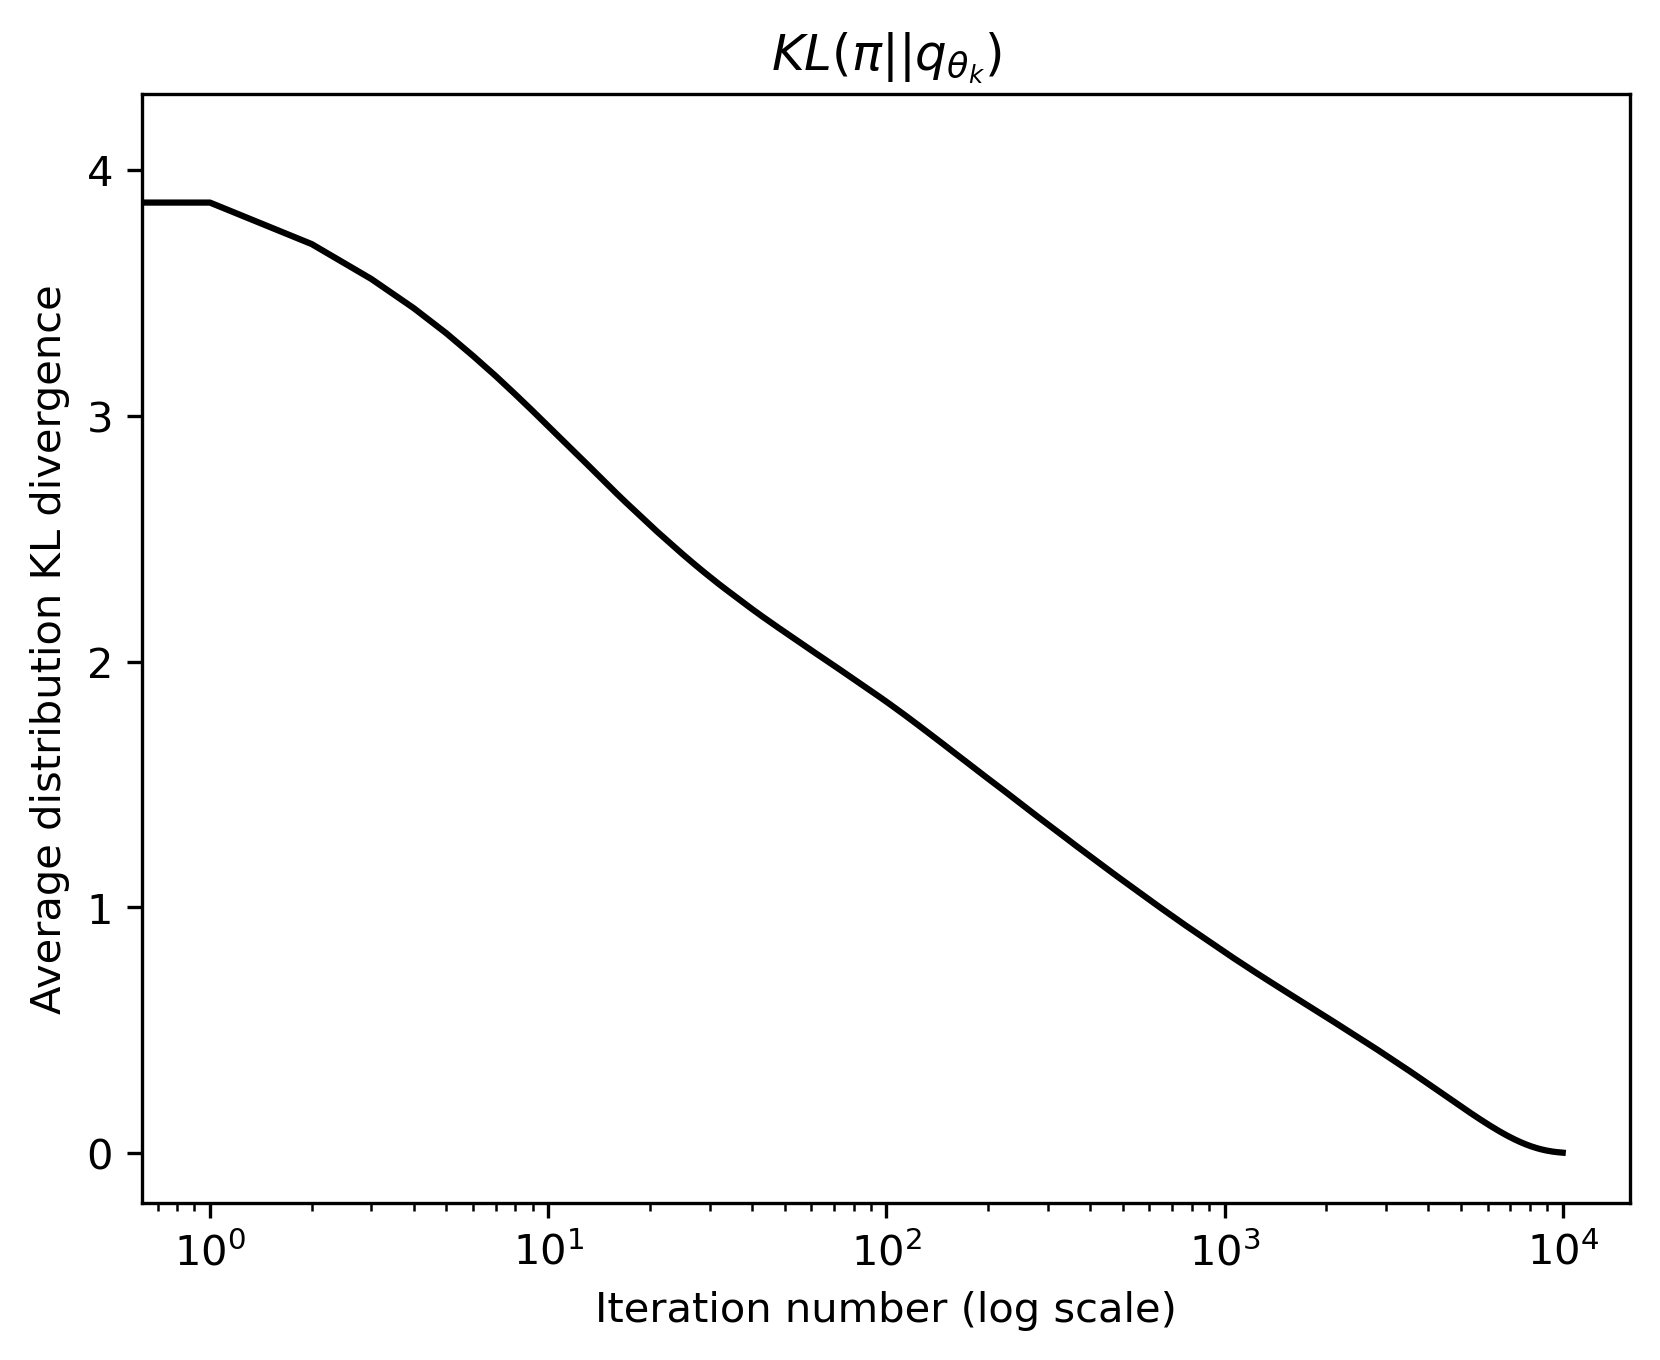

In [292]:
def KL(p, q):
    # from https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians

    sigma_p = p.Sigma
    sigma_q = q.Sigma
    mu_p = p.mu
    mu_q = q.mu

    return 0.5*(np.log(np.linalg.det(sigma_q)/np.linalg.det(sigma_p)) - len(mu_p) + np.trace(np.linalg.inv(sigma_q)@sigma_p) + (mu_q-mu_p).T@np.linalg.inv(sigma_q)@(mu_q-mu_p))

KL_divs = [KL(pi, d) for d in average_distributions]
plt.plot(KL_divs, color="black")
plt.title("$KL(\pi||q_{\\theta_k})$")
plt.xlabel("Iteration number (log scale)")
plt.xscale("log")
plt.ylabel("Average distribution KL divergence")
plt.show()


In [300]:
for d in tqdm(SG_average_distributions):
    fill_z(d, npoints=10)

  0%|          | 0/10001 [00:00<?, ?it/s]

 10%|▉         | 978/10001 [00:06<01:03, 141.79it/s]


KeyboardInterrupt: 

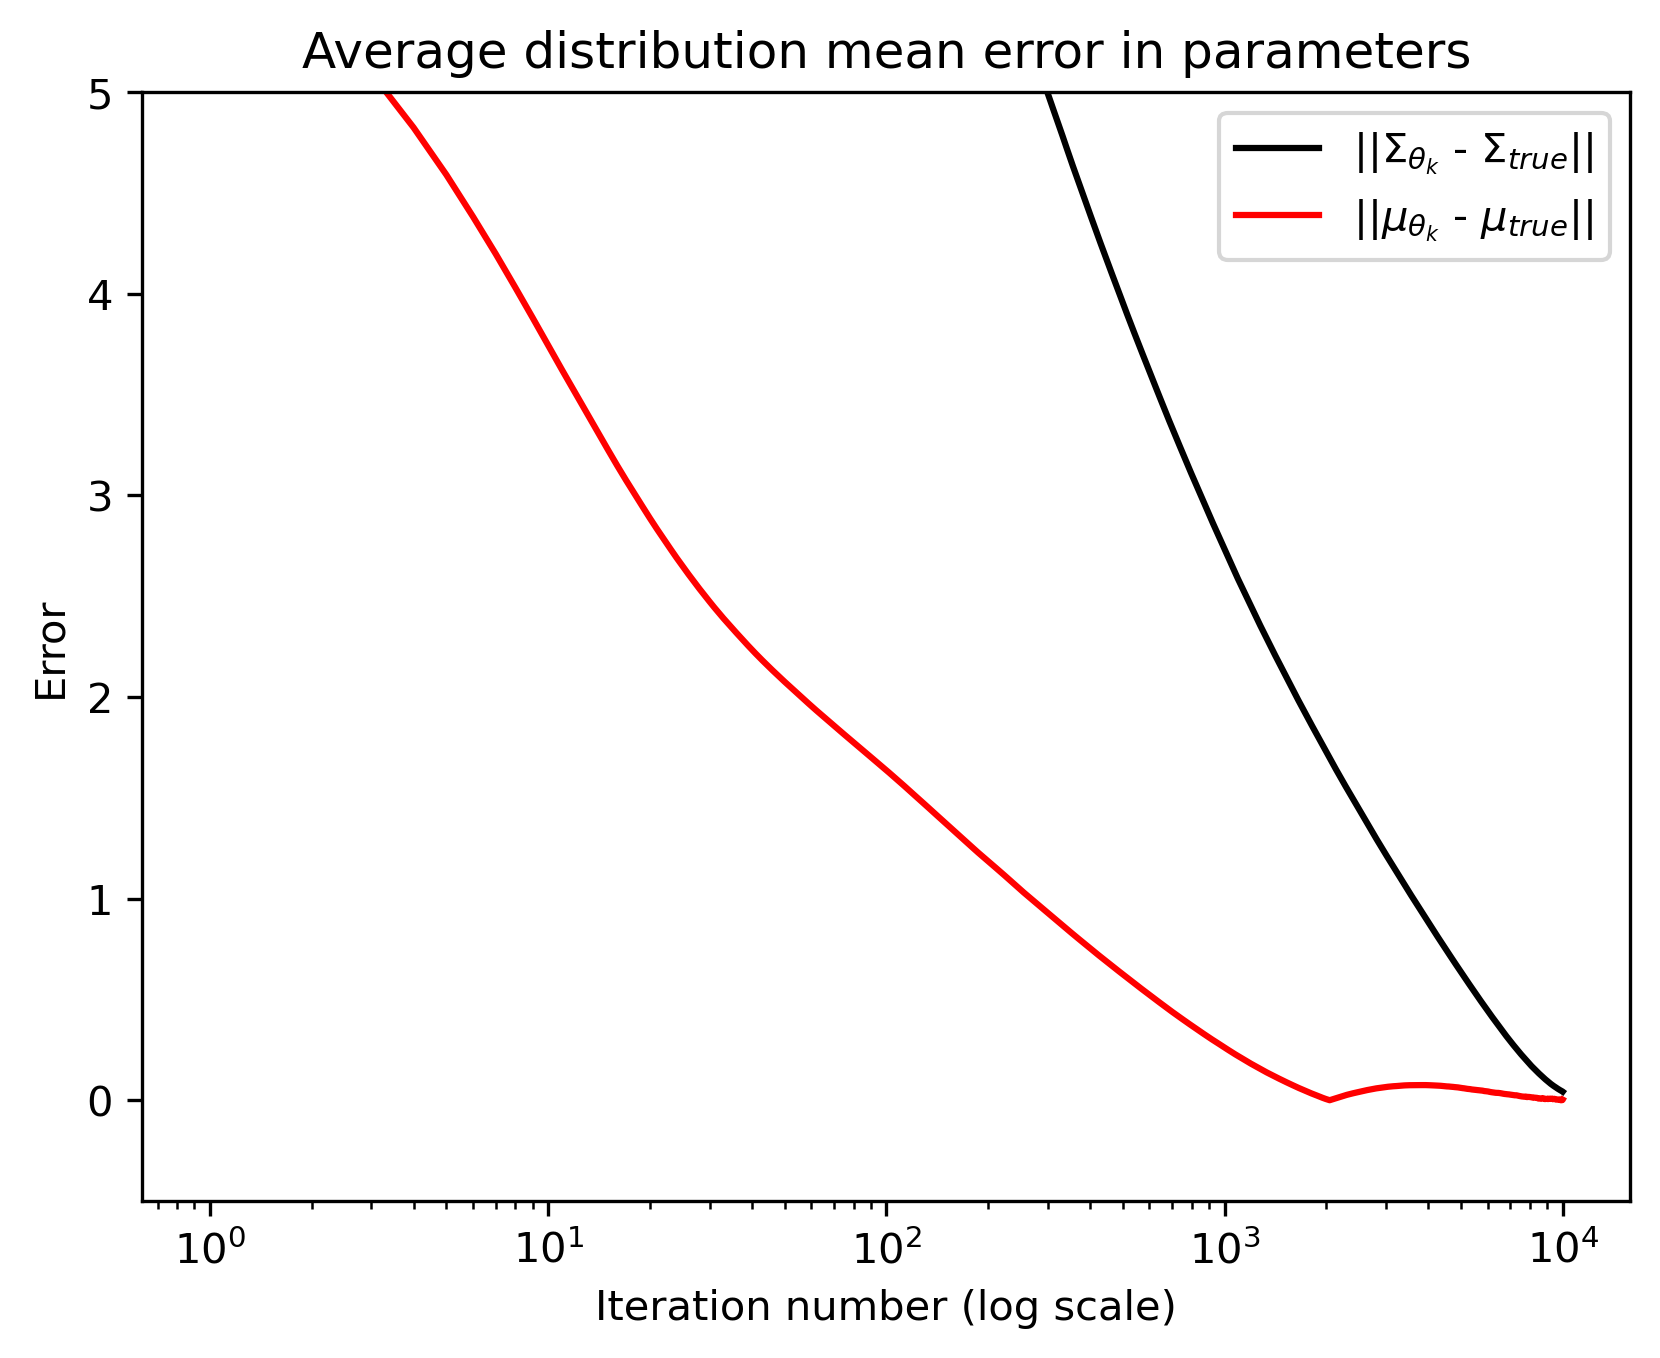

In [293]:
sigmas = [d.Sigma for d in average_distributions]
mus = [d.mu for d in average_distributions]
sigma_errors = [np.linalg.norm(s-pi.Sigma)/4 for s in sigmas]
mu_errors = [np.linalg.norm(m-pi.mu)/2 for m in mus]
plt.plot(sigma_errors, color="black", label="||$\Sigma_{\\theta_k}$ - $\Sigma_{true}$||")
plt.plot(mu_errors, color="red", label="||$\mu_{\\theta_k}$ - $\mu_{true}$||")
plt.title("Average distribution mean error in parameters")
plt.xlabel("Iteration number (log scale)")
plt.xscale("log")
plt.ylim(-0.5, 5)
plt.ylabel("Error")
plt.legend()
plt.show()

In [295]:
rho_arr = []
for d in tqdm(average_distributions):
    r = rho(pi, d, Nsamples = 10000)
    rho_arr.append(r)

100%|██████████| 10001/10001 [00:35<00:00, 280.07it/s]


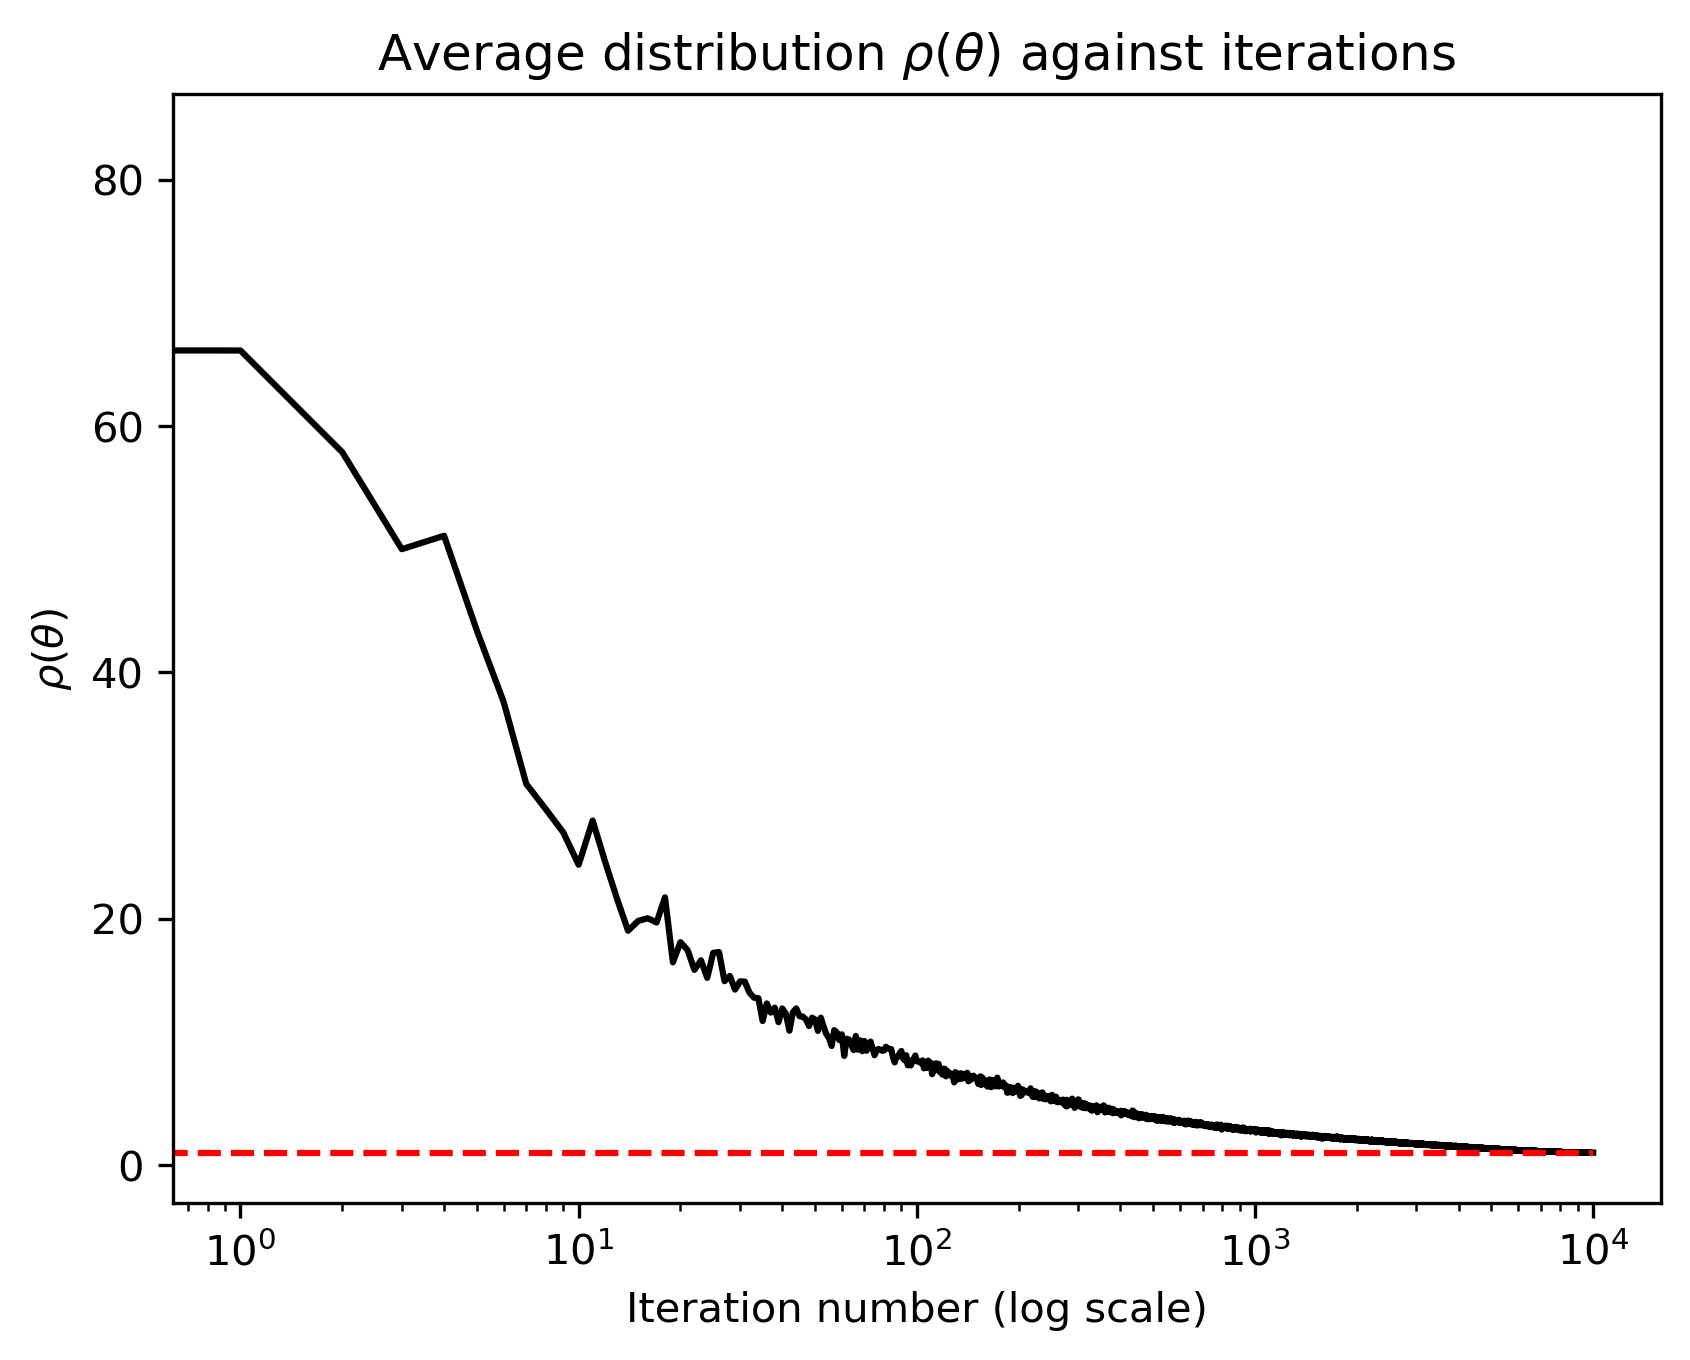

In [296]:
plt.plot([rho_val for rho_val in rho_arr], color="black")
plt.title("Average distribution $\\rho(\\theta)$ against iterations")
plt.xlabel("Iteration number (log scale)")
plt.xscale("log")
plt.ylabel("$\\rho(\\theta)$")
plt.hlines(1, colors="red", xmin=0, xmax=len(rho_arr), linestyles="dashed")
plt.show()


In [32]:
average_distributions[-1]

N([ 0.80459565 -1.57419241], [[ 2.41019237 -0.52682699]
 [-0.52682699  2.51854117]])

In [31]:
average_distributions[-1].mu - pi.mu

array([-0.19540435, -0.57419241])

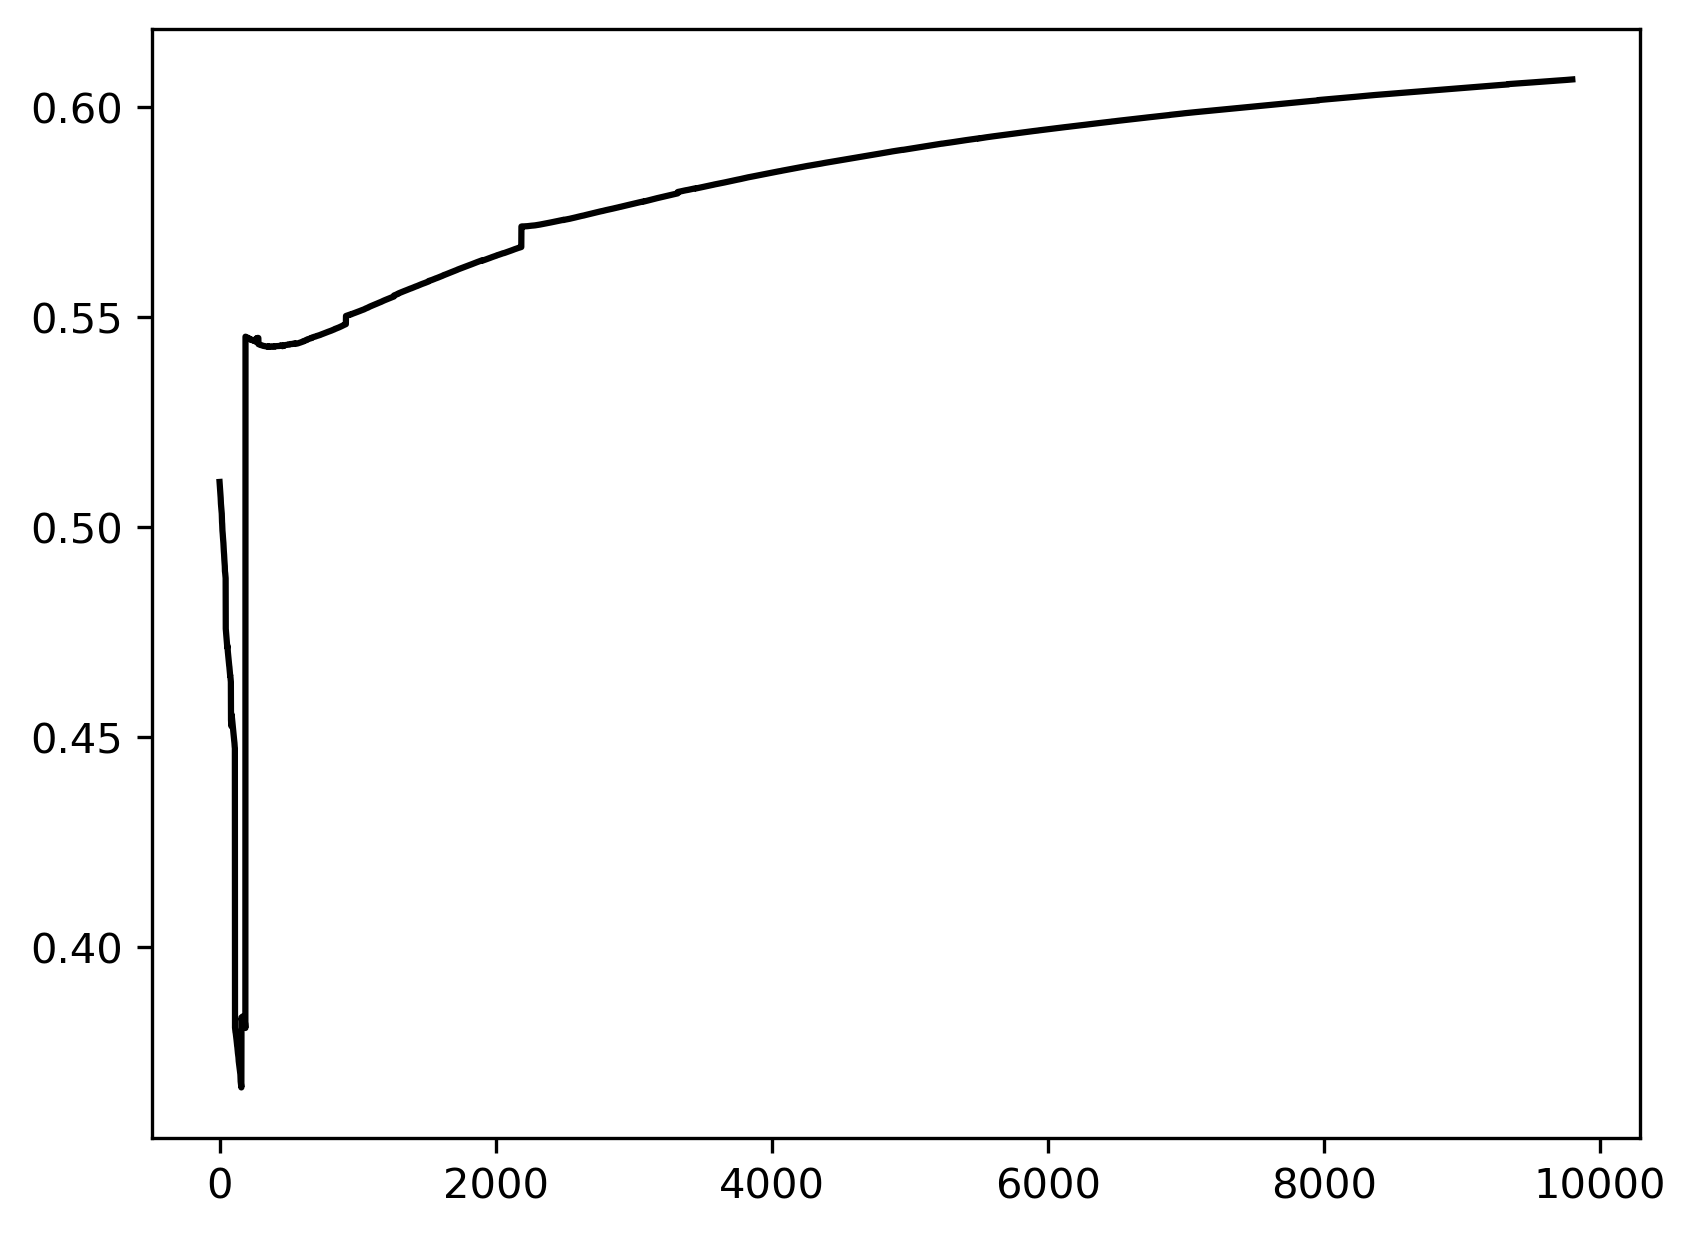

In [30]:
mus = [d.mu for d in average_distributions]
mu_errors = [np.linalg.norm(m-pi.mu) for m in mus][200:]
plt.plot(mu_errors, color="black")

In [ ]:
mus

[array([ 5, -5]),
 array([ 1.11339292, -1.09178831]),
 array([ 1.10009845, -1.08042915]),
 array([ 1.09081973, -1.07179102]),
 array([ 1.08346653, -1.06526782]),
 array([ 1.07759907, -1.05950216]),
 array([ 1.07087274, -1.05380301]),
 array([ 1.06561134, -1.04918655]),
 array([ 1.06107239, -1.04469866]),
 array([ 1.05659108, -1.0410255 ]),
 array([ 1.05269068, -1.03730949]),
 array([ 1.04878474, -1.0336818 ]),
 array([ 1.04550431, -1.03048403]),
 array([ 1.04197597, -1.02732152]),
 array([ 1.03883836, -1.02457194]),
 array([ 1.03611796, -1.02193138]),
 array([ 1.03339003, -1.01934965]),
 array([ 1.03070952, -1.01677197]),
 array([ 1.02803456, -1.01440199]),
 array([ 1.02583963, -1.01233176]),
 array([ 1.02340843, -1.0099804 ]),
 array([ 1.02132875, -1.00803275]),
 array([ 1.01918694, -1.00582489]),
 array([ 1.01749503, -1.00415087]),
 array([ 1.01540983, -1.00211793]),
 array([ 1.0134288 , -1.00020324]),
 array([ 1.0116654 , -0.99855013]),
 array([ 1.00988553, -0.99676094]),
 array([ 1

In [ ]:
pi.mu

array([ 1, -1])